# Chapter 18 – Reinforcement Learning**

_This notebook contains all the sample code in chapter 18_.

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/18_reinforcement_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml2/blob/master/18_reinforcement_learning.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup
First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if IS_COLAB or IS_KAGGLE:
    !apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
    %pip install -U tf-agents pyvirtualdisplay
    %pip install -U gym>=0.21.0
    %pip install -U gym[box2d,atari,accept-rom-license]

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Learning to Optimize Rewards  

In Reinforcement Learning, a software agent makes observations and takes actions within an environment, and in return it receives rewards. Its objective is to learn to act in a way that will maximize its expected rewards over time. If you don’t mind a bit of anthropomorphism, you can think of positive rewards as pleasure, and negative rewards as pain (the term “reward” is a bit misleading in this case). In short, the agent acts in the environment and learns by trial and error to maximize its pleasure and minimize its pain.

This is quite a broad setting, which can apply to a wide variety of tasks. Here are a few examples (see Figure 18-1):

  - 1. The agent can be the program controlling a robot. In this case, the environment is the real world, the agent observes the environment through a set of *sensors* such as cameras and touch sensors, and its actions consist of sending signals to activate motors. It may be programmed to get positive rewards whenever it approaches the target destination, and negative rewards whenever it wastes time or goes in the wrong direction.

  - 2. The agent can be the program controlling Ms. Pac-Man. In this case, the environment is a simulation of the Atari game, the actions are the nine possible joystick positions (upper left, down, center, and so on), the observations are screenshots, and the rewards are just the game points.

  - 3. Similarly, the agent can be the program playing a board game such as Go.

  - 4. The agent does not have to control a physically (or virtually) moving thing. For example, it can be a smart thermostat, getting positive rewards whenever it is close to the target temperature and saves energy, and negative rewards when humans need to tweak the temperature, so the agent must learn to anticipate human needs.

  - 5. The agent can observe stock market prices and decide how much to buy or sell every second. Rewards are obviously the monetary gains and losses.
  
<img src="./chapters/18/18-1.png">
<div style="text-align:center"> Figure 18-1. Reinforcement Learning examples: (a) robotics, (b) Ms. Pac-Man, (c) Go player, (d) thermostat, (e) automatic trader </div> 

Note that there may not be any positive rewards at all; for example, the agent may move around in a maze, getting a negative reward at every time step, so it had better find the exit as quickly as possible! There are many other examples of tasks to which Reinforcement Learning is well suited, such as self-driving cars, recommender systems, placing ads on a web page, or controlling where an image classification system should focus its attention.

##  Policy Search  

The algorithm a software agent uses to determine its actions is called its *policy*. The policy could be a neural network taking observations as inputs and outputting the action to take (see Figure 18-2). 

<img src="./chapters/18/18-2.png">
<div style="text-align:center"> Figure 18-2. Reinforcement Learning using a neural network policy </div>  

The policy can be any algorithm you can think of, and it does not have to be deterministic. In fact, in some cases it does not even have to observe the environment! For example, consider a robotic vacuum cleaner whose reward is the amount of dust it picks up in 30 minutes. Its policy could be to move forward with some probability $p$ every second, or randomly rotate left or right with probability $1 – p$. The rotation angle would be a random angle between $-r$ and $+r$. Since this policy involves some randomness, it is called a *stochastic policy*. The robot will have an erratic trajectory, which guarantees that it will eventually get to any place it can reach and pick up all the dust. The question is, how much dust will it pick up in 30 minutes?

How would you train such a robot? There are just two policy parameters you can tweak: the probability $p$ and the angle range $r$. One possible learning algorithm could be to try out many different values for these parameters, and pick the combination that performs best (see Figure 18-3). This is an example of *policy search*, in this case using a brute force approach. When the *policy space* is too large (which is generally the case), finding a good set of parameters this way is like searching for a needle in a gigantic haystack.

Another way to explore the policy space is to use *genetic algorithms*. For example, you could randomly create a first generation of 100 policies and try them out, then “kill” the 80 worst policies and make the 20 survivors produce 4 offspring each. An offspring is a copy of its parent plus some random variation. The surviving policies plus their offspring together constitute the second generation. You can continue to iterate through generations this way until you find a good policy.

<img src="./chapters/18/18-3.png">
<div style="text-align:center"> Figure 18-3. Four points in policy space (left) and the agent’s corresponding behavior (right) </div>   

Yet another approach is to use optimization techniques, by evaluating the gradients of the rewards with regard to the policy parameters, then tweaking these parameters by following the gradients toward higher rewards. We will discuss this approach, is called *policy gradients* (PG), in more detail later in this chapter. Going back to the vacuum cleaner robot, you could slightly increase $p$ and evaluate whether doing so increases the amount of dust picked up by the robot in 30 minutes; if it does, then increase $p$ some more, or else reduce $p$. We will implement a popular PG algorithm using TensorFlow, but before we do, we need to create an environment for the agent to live in⁠—so it’s time to introduce OpenAI Gym.

## Introduction to OpenAI gym

One of the challenges of Reinforcement Learning is that in order to train an agent, you first need to have a working environment. If you want to program an agent that will learn to play an Atari game, you will need an Atari game simulator. If you want to program a walking robot, then the environment is the real world, and you can directly train your robot in that environment, but this has its limits: if the robot falls off a cliff, you can’t just click Undo. You can’t speed up time either; adding more computing power won’t make the robot move any faster. And it’s generally too expensive to train 1,000 robots in parallel. In short, training is hard and slow in the real world, so you generally need a simulated environment at least for bootstrap training. For example, you may use a library like `PyBullet` or `MuJoCo` for 3D physics simulation.

`OpenAI Gym` is a toolkit that provides a wide variety of simulated environments (Atari games, board games, 2D and 3D physical simulations, and so on), so you can train agents, compare them, or develop new RL algorithms.

In this notebook we will be using [OpenAI gym](https://gym.openai.com/), a great toolkit for developing and comparing Reinforcement Learning algorithms. It provides many environments for your learning *agents* to interact with. Let's start by importing `gym`: 

Depending on your system, you may also need to install the Mesa OpenGL Utility (GLU) library (e.g., on Ubuntu 18.04 you need to run `apt install libglu1-mesa`). This library will be needed to render the first environment. Next, open up a Python shell or a Jupyter notebook and create an environment with `make()`:

In [2]:
import gym

Let's list all the available environments:

In [3]:
gym.envs.registry.all()

ValuesView(├──ALE
│   ├──ALE/Tetris: [ v5 ]
│   ├──ALE/Tetris-ram: [ v5 ]
│   ├──ALE/Adventure: [ v5 ]
│   ├──ALE/Adventure-ram: [ v5 ]
│   ├──ALE/AirRaid: [ v5 ]
│   ├──ALE/AirRaid-ram: [ v5 ]
│   ├──ALE/Alien: [ v5 ]
│   ├──ALE/Alien-ram: [ v5 ]
│   ├──ALE/Amidar: [ v5 ]
│   ├──ALE/Amidar-ram: [ v5 ]
│   ├──ALE/Assault: [ v5 ]
│   ├──ALE/Assault-ram: [ v5 ]
│   ├──ALE/Asterix: [ v5 ]
│   ├──ALE/Asterix-ram: [ v5 ]
│   ├──ALE/Asteroids: [ v5 ]
│   ├──ALE/Asteroids-ram: [ v5 ]
│   ├──ALE/Atlantis: [ v5 ]
│   ├──ALE/Atlantis-ram: [ v5 ]
│   ├──ALE/Atlantis2: [ v5 ]
│   ├──ALE/Atlantis2-ram: [ v5 ]
│   ├──ALE/Backgammon: [ v5 ]
│   ├──ALE/Backgammon-ram: [ v5 ]
│   ├──ALE/BankHeist: [ v5 ]
│   ├──ALE/BankHeist-ram: [ v5 ]
│   ├──ALE/BasicMath: [ v5 ]
│   ├──ALE/BasicMath-ram: [ v5 ]
│   ├──ALE/BattleZone: [ v5 ]
│   ├──ALE/BattleZone-ram: [ v5 ]
│   ├──ALE/BeamRider: [ v5 ]
│   ├──ALE/BeamRider-ram: [ v5 ]
│   ├──ALE/Berzerk: [ v5 ]
│   ├──ALE/Berzerk-ram: [ v5 ]
│   ├──ALE/Blackjack: [ 

The Cart-Pole is a very simple environment composed of a cart that can move left or right, and pole placed vertically on top of it. The agent must move the cart left or right to keep the pole upright.

In [4]:
env = gym.make('CartPole-v1')

Let's initialize the environment by calling is `reset()` method. This returns an observation:

In [5]:
#env.seed(42)
obs = env.reset()

Here, we’ve created a CartPole environment. This is a 2D simulation in which a cart can be accelerated left or right in order to balance a pole placed on top of it (see Figure 18-4). You can get the list of all available environments by running `gym.envs.registry.all()`. After the environment is created, you must initialize it using the `reset()` method. This returns the first observation. Observations depend on the type of environment. For the CartPole environment, each observation is a 1D NumPy array containing four floats: these floats represent the cart’s horizontal position (0.0 = center), its velocity (positive means right), the angle of the pole (0.0 = vertical), and its angular velocity (positive means clockwise).

Now let’s display this environment by calling its `render()` method (see Figure 18-4). On Windows, this requires first installing an X Server, such as `VcXsrv` or `Xming`: 

<img src="./chapters/18/18-4.png">
<div style="text-align:center"> Figure 18-4. The CartPole environment </div>   


In [6]:
obs

array([ 0.00439836, -0.0058017 ,  0.04190864, -0.02982666], dtype=float32)

An environment can be visualized by calling its `render()` method, and you can pick the rendering mode (the rendering options depend on the environment).

**Warning**: some environments (including the Cart-Pole) require access to your display, which opens up a separate window, even if you specify `mode="rgb_array"`. In general you can safely ignore that window. However, if Jupyter is running on a headless server (ie. without a screen) it will raise an exception. One way to avoid this is to install a fake X server like [Xvfb](http://en.wikipedia.org/wiki/Xvfb). On Debian or Ubuntu:

```bash
$ apt update
$ apt install -y xvfb
```

You can then start Jupyter using the `xvfb-run` command:

```bash
$ xvfb-run -s "-screen 0 1400x900x24" jupyter notebook
```

Alternatively, you can install the [pyvirtualdisplay](https://github.com/ponty/pyvirtualdisplay) Python library which wraps Xvfb:

```bash
%pip install -U pyvirtualdisplay
```

And run the following code:

In [7]:
#env.render()

If you want `render()` to return the rendered image as a NumPy array, you can set `mode="rgb_array"` (oddly, this environment will render the environment to screen as well):

In [8]:
img = env.render(mode="rgb_array")
img.shape # height, width, channels (3 = Red, Green, Blue)

(400, 600, 3)

In [9]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

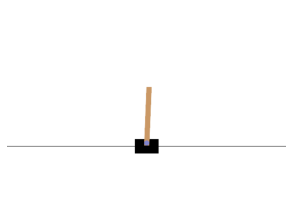

In [10]:
plot_environment(env)
plt.show()

Let's see how to interact with an environment. Your agent will need to select an action from an "action space" (the set of possible actions). Let's see what this environment's action space looks like:

In [11]:
env.action_space

Discrete(2)

`Discrete(2)` means that the possible actions are integers `0` and `1`, which represent accelerating left (0) or right (1). Other environments may have additional discrete actions, or other kinds of actions (e.g., continuous). Since the pole is leaning toward the right (`obs[2] > 0`), let’s accelerate the cart toward the right:

In [12]:
action = 1  # accelerate right
obs, reward, done, info = env.step(action)
obs

array([ 0.00428232,  0.18869498,  0.04131211, -0.308998  ], dtype=float32)

For the CartPole environment, each observation is a 1D NumPy array containing four floats: these floats represent the cart’s horizontal position (0.0 = center), its velocity (positive means right), the angle of the pole (0.0 = vertical), and its angular velocity (positive means clockwise). Notice that the cart is now moving toward the right (`obs[1] > 0`). The pole is still tilted toward the right (`obs[2] > 0`), but its angular velocity is now negative (`obs[3] < 0`), so it will likely be tilted toward the left after the next step.  

The `step()` method executes the given action and returns four values:

`obs` 
  
This is the new observation. The cart is now moving toward the right (`obs[1] > 0`). The pole is still tilted toward the right (`obs[2] > 0`), but its angular velocity is now negative (`obs[3] < 0`), so it will likely be tilted toward the left after the next step.

`reward` 


In this environment, you get a reward of `1.0` at every step, no matter what you do, so the goal is to keep the episode running as long as possible.

`done` 


This value will be `True` when the episode is over. This will happen when the pole tilts too much, or goes off the screen, or after 200 steps (in this last case, you have won). After that, the environment must be reset before it can be used again.

`info` 

This environment-specific dictionary can provide some extra information that you may find useful for debugging or for training. For example, in some games it may indicate how many lives the agent has.

Saving figure cart_pole_plot


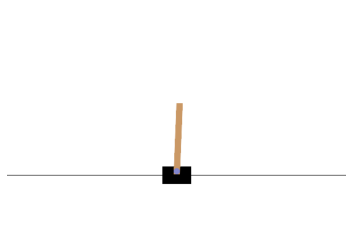

In [13]:
plot_environment(env)
save_fig("cart_pole_plot")

Looks like it's doing what we're telling it to do!

The environment also tells the agent how much reward it got during the last step:

In [14]:
reward

1.0

When the game is over, the environment returns `done=True`:

In [15]:
done

False

In [16]:
info

{}

Once you have finished using an environment, you should call its `close()` method to free resources.

The sequence of steps between the moment the environment is reset until it is done is called an "episode". At the end of an episode (i.e., when `step()` returns `done=True`), you should reset the environment before you continue to use it.

In [17]:
if done:
    obs = env.reset()

Now how can we make the pole remain upright? We will need to define a _policy_ for that. This is the strategy that the agent will use to select an action at each step. It can use all the past actions and observations to decide what to do.

### A simple hard-coded policy 

Let’s hardcode a simple policy that accelerates left when the pole is leaning toward the left and accelerates right when the pole is leaning toward the right. We will run this policy to see the average rewards it gets over 500 episodes:

In [18]:
#env.seed(42)

def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

In [19]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(41.798, 8.743980558075366, 24.0, 68.0)

Well, as expected, this strategy is a bit too basic: the best it did was to keep the pole up for only 66 steps. This environment is considered solved when the agent keeps the pole up for 200 steps.

Let's visualize one episode:

In [20]:
#env.seed(42)

frames = []

obs = env.reset()
for step in range(200):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = basic_policy(obs)

    obs, reward, done, info = env.step(action)
    if done:
        break

Now show the animation:

In [21]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [23]:
plot_animation(frames)

Clearly the system is unstable and after just a few wobbles, the pole ends up too tilted: game over. We will need to be smarter than that!

## Neural Network Policies 

Let’s create a neural network policy. Just like with the policy we hardcoded earlier, this neural network will take an observation as input, and it will output the action to be executed. More precisely, it will estimate a probability for each action, and then we will select an action randomly, according to the estimated probabilities (see Figure 18-5). In the case of the CartPole environment, there are just two possible actions (left or right), so we only need one output neuron. It will output the probability $p$ of action $0$ (left), and of course the probability of action $1$ (right) will be $1 - p$. For example, if it outputs $0.7$, then we will pick action $0$ with 70% probability, or action $1$ with 30% probability. 

<img src="./chapters/18/18-5.png">
<div style="text-align:center"> Figure 18-5. Neural network policy </div>   


You may wonder why we are picking a random action based on the probabilities given by the neural network, rather than just picking the action with the highest score. This approach lets the agent find the right balance between exploring new actions and exploiting the actions that are known to work well. Here’s an analogy: suppose you go to a restaurant for the first time, and all the dishes look equally appealing, so you randomly pick one. If it turns out to be good, you can increase the probability that you’ll order it next time, but you shouldn’t increase that probability up to 100%, or else you will never try out the other dishes, some of which may be even better than the one you tried.

Also note that in this particular environment, the past actions and observations can safely be ignored, since each observation contains the environment’s full state. If there were some hidden state, then you might need to consider past actions and observations as well. For example, if the environment only revealed the position of the cart but not its velocity, you would have to consider not only the current observation but also the previous observation in order to estimate the current velocity. Another example is when the observations are noisy; in that case, you generally want to use the past few observations to estimate the most likely current state. The CartPole problem is thus as simple as can be; the observations are noise-free, and they contain the environment’s full state.

Here is the code to build this neural network policy using `tf.keras`:

In [24]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

n_inputs = 4 # == env.observation_space.shape[0]

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[n_inputs]),
    keras.layers.Dense(1, activation="sigmoid"),
])

After the imports, we use a simple `Sequential` model to define the policy network. The number of inputs is the size of the observation space (which in the case of CartPole is `4`), and we have just five hidden units because it’s a simple problem. Finally, we want to output a single probability (the probability of going left), so we have a single output neuron using the `sigmoid` activation function. If there were more than two possible actions, there would be one output neuron per action, and we would use the `softmax` activation function instead.



Let's write a small function that will run the model to play one episode, and return the frames so we can display an animation:

In [25]:
def render_policy_net(model, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1")
    #env.seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        left_proba = model.predict(obs.reshape(1, -1))
        action = int(np.random.rand() > left_proba)
        obs, reward, done, info = env.step(action)
        if done:
            break
    env.close()
    return frames

Now let's look at how well this randomly initialized policy network performs:

In [26]:
frames = render_policy_net(model)
plot_animation(frames)

Yeah... pretty bad. The neural network will have to learn to do better. First let's see if it is capable of learning the basic policy we used earlier: go left if the pole is tilting left, and go right if it is tilting right.

We can make the same net play in 50 different environments in parallel (this will give us a diverse training batch at each step), and train for 5000 iterations. We also reset environments when they are done. We train the model using a custom training loop so we can easily use the predictions at each training step to advance the environments.

In [27]:
n_environments = 50
n_iterations = 5000

envs = [gym.make("CartPole-v1") for _ in range(n_environments)]
#for index, env in enumerate(envs):
#    env.seed(index)
np.random.seed(42)
observations = [env.reset() for env in envs]
optimizer = keras.optimizers.RMSprop()
loss_fn = keras.losses.binary_crossentropy

for iteration in range(n_iterations):
    # if angle < 0, we want proba(left) = 1., or else proba(left) = 0.
    target_probas = np.array([([1.] if obs[2] < 0 else [0.])
                              for obs in observations])
    with tf.GradientTape() as tape:
        left_probas = model(np.array(observations))
        loss = tf.reduce_mean(loss_fn(target_probas, left_probas))
    print("\rIteration: {}, Loss: {:.3f}".format(iteration, loss.numpy()), end="")
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    actions = (np.random.rand(n_environments, 1) > left_probas.numpy()).astype(np.int32)
    for env_index, env in enumerate(envs):
        obs, reward, done, info = env.step(actions[env_index][0])
        observations[env_index] = obs if not done else env.reset()

for env in envs:
    env.close()

Iteration: 4999, Loss: 0.050

In [28]:
frames = render_policy_net(model)
plot_animation(frames)

Looks like it learned the policy correctly. Now let's see if it can learn a better policy on its own. One that does not wobble as much.

## Evaluating Actions: The Credit Assignment Problem  


If we knew what the best action was at each step, we could train the neural network as usual, by minimizing the cross entropy between the estimated probability distribution and the target probability distribution. It would just be regular supervised learning. However, in Reinforcement Learning the only guidance the agent gets is through rewards, and rewards are typically sparse and delayed. For example, if the agent manages to balance the pole for 100 steps, how can it know which of the 100 actions it took were good, and which of them were bad? All it knows is that the pole fell after the last action, but surely this last action is not entirely responsible. This is called the *credit assignment problem*: when the agent gets a reward, it is hard for it to know which actions should get credited (or blamed) for it. Think of a dog that gets rewarded hours after it behaved well; will it understand what it is being rewarded for?  

To tackle this problem, a common strategy is to evaluate an action based on the sum of all the rewards that come after it, usually applying a *discount factor* $\gamma$ (gamma) at each step. This sum of discounted rewards is called the action’s *return*. Consider the example in Figure 18-6). If an agent decides to go right three times in a row and gets `+10` reward after the first step, `0` after the second step, and finally `–50` after the third step, then assuming we use a discount factor $\gamma = 0.8$, the first action will have a return of $10 + \gamma \times 0 + \gamma^2 \times (-50) = -22$. If the discount factor is close to $0$, then future rewards won’t count for much compared to immediate rewards. Conversely, if the discount factor is close to $1$, then rewards far into the future will count almost as much as immediate rewards. Typical discount factors vary from $0.9$ to $0.99$. With a discount factor of $0.95$, rewards 13 steps into the future count roughly for half as much as immediate rewards (since $0.95^{13} ≈ 0.5$), while with a discount factor of $0.99$, rewards 69 steps into the future count for half as much as immediate rewards. In the CartPole environment, actions have fairly short-term effects, so choosing a discount factor of $0.95$ seems reasonable. 

<img src="./chapters/18/18-6.png">
<div style="text-align:center"> Figure 18-6. Computing an action’s return: the sum of discounted future rewards </div>   

Of course, a good action may be followed by several bad actions that cause the pole to fall quickly, resulting in the good action getting a low return (similarly, a good actor may sometimes star in a terrible movie). However, if we play the game enough times, on average good actions will get a higher return than bad ones. We want to estimate how much better or worse an action is, compared to the other possible actions, on average. This is called the *action advantage*. For this, we must run many episodes and normalize all the action returns (by subtracting the mean and dividing by the standard deviation). After that, we can reasonably assume that actions with a negative advantage were bad while actions with a positive advantage were good. Perfect—now that we have a way to evaluate each action, we are ready to train our first agent using policy gradients. Let’s see how.

In [29]:
10-0.8**2*50, 0.95**13, 0.99**69

(-22.000000000000007, 0.5133420832795048, 0.4998370298991989)

## Policy Gradients  

As discussed earlier, PG algorithms optimize the parameters of a policy by following the gradients toward higher rewards. One popular class of PG algorithms, called *REINFORCE algorithms*, was introduced back in 1992 by Ronald Williams. Here is one common variant:

  - First, let the neural network policy play the game several times, and at each step, compute the gradients that would make the chosen action even more likely—but don’t apply these gradients yet.

  - Once you have run several episodes, compute each action’s advantage (using the method described in the previous section).

  - If an action’s advantage is positive, it means that the action was probably good, and you want to apply the gradients computed earlier to make the action even more likely to be chosen in the future. However, if the action’s advantage is negative, it means the action was probably bad, and you want to apply the opposite gradients to make this action slightly less likely in the future. The solution is simply to multiply each gradient vector by the corresponding action’s advantage.

  - Finally, compute the mean of all the resulting gradient vectors, and use it to perform a Gradient Descent step.

Let’s use `tf.keras` to implement this algorithm. We will train the neural network policy we built earlier so that it learns to balance the pole on the cart. First, we need a function that will play one step. We will pretend for now that whatever action it takes is the right one so that we can compute the loss and its gradients (these gradients will just be saved for a while, and we will modify them later depending on how good or bad the action turned out to be):


To train this neural network we will need to define the target probabilities `y`. If an action is good we should increase its probability, and conversely if it is bad we should reduce it. But how do we know whether an action is good or bad? The problem is that most actions have delayed effects, so when you win or lose points in an episode, it is not clear which actions contributed to this result: was it just the last action? Or the last 10? Or just one action 50 steps earlier? This is called the _credit assignment problem_.

The _Policy Gradients_ algorithm tackles this problem by first playing multiple episodes, then making the actions in good episodes slightly more likely, while actions in bad episodes are made slightly less likely. First we play, then we go back and think about what we did.

Let's start by creating a function to play a single step using the model. We will also pretend for now that whatever action it takes is the right one, so we can compute the loss and its gradients (we will just save these gradients for now, and modify them later depending on how good or bad the action turned out to be):

In [30]:
import tensorflow as tf
tf.random.uniform([1, 1])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.7413678]], dtype=float32)>

In [31]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(int(action[0, 0].numpy()))
    return obs, reward, done, grads

Let’s walk though this function:

  - Within the `GradientTape` block (see Chapter 12), we start by calling the model, giving it a single observation (we reshape the observation so it becomes a batch containing a single instance, as the model expects a batch). This outputs the probability of going left.

  - Next, we sample a random float between 0 and 1, and we check whether it is greater than `left_proba`. The action will be `False` with probability `left_proba`, or `True` with probability `1 - left_proba`. Once we cast this Boolean to a number, the action will be 0 (left) or 1 (right) with the appropriate probabilities.

  - Next, we define the target probability of going left: it is 1 minus the action (cast to a float). If the action is 0 (left), then the target probability of going left will be 1. If the action is 1 (right), then the target probability will be 0.

  - Then we compute the loss using the given loss function, and we use the tape to compute the gradient of the loss with regard to the model’s trainable variables. Again, these gradients will be tweaked later, before we apply them, depending on how good or bad the action turned out to be.

  - Finally, we play the selected action, and we return the new observation, the reward, whether the episode is ended or not, and of course the gradients that we just computed.

Now let’s create another function that will rely on the `play_one_step()` function to play multiple episodes, returning all the rewards and gradients for each episode and each step:

If `left_proba` is high, then `action` will most likely be `False` (since a random number uniformally sampled between 0 and 1 will probably not be greater than `left_proba`). And `False` means 0 when you cast it to a number, so `y_target` would be equal to 1 - 0 = 1. In other words, we set the target to 1, meaning we pretend that the probability of going left should have been 100% (so we took the right action).

Now let's create another function that will rely on the `play_one_step()` function to play multiple episodes, returning all the rewards and gradients, for each episode and each step:

In [32]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

This code returns a list of reward lists (one reward list per episode, containing one reward per step), as well as a list of gradient lists (one gradient list per episode, each containing one tuple of gradients per step and each tuple containing one gradient tensor per trainable variable).

The algorithm will use the `play_multiple_episodes()` function to play the game several times (e.g., 10 times), then it will go back and look at all the rewards, discount them, and normalize them. To do that, we need a couple more functions: the first will compute the sum of future discounted rewards at each step, and the second will normalize all these discounted rewards (returns) across many episodes by subtracting the mean and dividing by the standard deviation:

The Policy Gradients algorithm uses the model to play the episode several times (e.g., 10 times), then it goes back and looks at all the rewards, discounts them and normalizes them. So let's create couple functions for that: the first will compute discounted rewards; the second will normalize the discounted rewards across many episodes.

In [33]:
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

Say there were 3 actions, and after each action there was a reward: first 10, then 0, then -50. If we use a discount factor of 80%, then the 3rd action will get -50 (full credit for the last reward), but the 2nd action will only get -40 (80% credit for the last reward), and the 1st action will get 80% of -40 (-32) plus full credit for the first reward (+10), which leads to a discounted reward of -22:

In [34]:
discount_rewards([10, 0, -50], discount_rate=0.8)

array([-22, -40, -50])

To normalize all discounted rewards across all episodes, we compute the mean and standard deviation of all the discounted rewards, and we subtract the mean from each discounted reward, and divide by the standard deviation:

In [35]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [36]:
import numpy as np
([-22, -40, -50, 26, 20]-np.mean([-22, -40, -50, 26, 20]))/np.std([-22, -40, -50, 26, 20])

array([-0.28435071, -0.86597718, -1.18910299,  1.26665318,  1.0727777 ])

The call to `discount_rewards()` returns exactly what we expect (see Figure 18-6). You can verify that the function `discount_and_normalize_rewards()` does indeed return the normalized action advantages for each action in both episodes. Notice that the first episode was much worse than the second, so its normalized advantages are all negative; all actions from the first episode would be considered bad, and conversely all actions from the second episode would be considered good.

We are almost ready to run the algorithm! Now let’s define the hyperparameters. We will run 150 training iterations, playing 10 episodes per iteration, and each episode will last at most 200 steps. We will use a discount factor of 0.95:

In [37]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_rate = 0.95

We also need an optimizer and the loss function. A regular `Adam` optimizer with learning rate `0.01` will do just fine, and we will use the `binary cross-entropy` loss function because we are training a binary classifier (there are two possible actions: left or right):

In [38]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
loss_fn = keras.losses.binary_crossentropy

In [39]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[4]),
    keras.layers.Dense(1, activation="sigmoid"),
])

In [40]:
env = gym.make("CartPole-v1")
#env.seed(42);

for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
    total_rewards = sum(map(sum, all_rewards))                     # Not shown in the book
    print("\rIteration: {}, mean rewards: {:.1f}".format(          # Not shown
        iteration, total_rewards / n_episodes_per_update), end="") # Not shown
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_rate)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

env.close()

Iteration: 149, mean rewards: 169.2

Let’s walk through this code:

  - At each training iteration, this loop calls the `play_multiple_episodes()` function, which plays the game 10 times and returns all the rewards and gradients for every episode and step.

  - Then we call the `discount_and_normalize_rewards()` to compute each action’s normalized advantage (which in the code we call the `final_reward`). This provides a measure of how good or bad each action actually was, in hindsight.

  - Next, we go through each trainable variable, and for each of them we compute the weighted mean of the gradients for that variable over all episodes and all steps, weighted by the `final_reward`.

  - Finally, we apply these mean gradients using the optimizer: the model’s trainable variables will be tweaked, and hopefully the policy will be a bit better.

And we’re done! This code will train the neural network policy, and it will successfully learn to balance the pole on the cart. The mean reward per episode will get very close to 200 (which is the maximum by default with this environment). Success!

TIP  


Researchers try to find algorithms that work well even when the agent initially knows nothing about the environment. However, unless you are writing a paper, you should not hesitate to inject prior knowledge into the agent, as it will speed up training dramatically. For example, since you know that the pole should be as vertical as possible, you could add negative rewards proportional to the pole’s angle. This will make the rewards much less sparse and speed up training. Also, if you already have a reasonably good policy (e.g., hardcoded), you may want to train the neural network to imitate it before using policy gradients to improve it.  



In [41]:
def render_policy_net(model, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1")
    #env.seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        left_proba = model.predict(obs.reshape(1, -1))
        action = int(np.random.rand() > left_proba)
        obs, reward, done, info = env.step(action)
        if done:
            break
    env.close()
    return frames

In [42]:
frames = render_policy_net(model)
plot_animation(frames)

The simple policy gradients algorithm we just trained solved the CartPole task, but it would not scale well to larger and more complex tasks. Indeed, it is highly sample inefficient, meaning it needs to explore the game for a very long time before it can make significant progress. This is due to the fact that it must run multiple episodes to estimate the advantage of each action, as we have seen. However, it is the foundation of more powerful algorithms, such as *Actor-Critic* algorithms (which we will discuss briefly at the end of this chapter).

We will now look at another popular family of algorithms. Whereas PG algorithms directly try to optimize the policy to increase rewards, the algorithms we will look at now are less direct: the agent learns to estimate the expected return for each state, or for each action in each state, then it uses this knowledge to decide how to act. To understand these algorithms, we must first introduce *Markov decision processes*.

## Markov chain


In the early 20th century, the mathematician Andrey Markov studied stochastic processes with no memory, called **Markov chains**. Such a process has a fixed number of states, and it randomly evolves from one state to another at each step. The probability for it to evolve from a state s to a state s′ is fixed, and it depends only on the pair (s, s′), not on past states (this is why we say that the system has no memory).

Figure 18-7 shows an example of a Markov chain with four states.


<img src="./chapters/18/18-7.png">
<div style="text-align:center"> Figure 18-7. Example of a Markov chain </div>  

Suppose that the process starts in state $s_0$, and there is a 70% chance that it will remain in that state at the next step. Eventually it is bound to leave that state and never come back because no other state points back to $s_0$. If it goes to state $s_1$, it will then most likely go to state $s_2$ (90% probability), then immediately back to state $s_1$ (with 100% probability). It may alternate a number of times between these two states, but eventually it will fall into state $s_3$ and remain there forever (this is a terminal state). Markov chains can have very different dynamics, and they are heavily used in thermodynamics, chemistry, statistics, and much more.


In [1]:
import numpy as np
np.random.seed(42)

transition_probabilities = [ # shape=[s, s']
        [0.7, 0.2, 0.0, 0.1],  # from s0 to s0, s1, s2, s3
        [0.0, 0.0, 0.9, 0.1],  # from s1 to ...
        [0.0, 1.0, 0.0, 0.0],  # from s2 to ...
        [0.0, 0.0, 0.0, 1.0]]  # from s3 to ...

n_max_steps = 50

def print_sequence():
    current_state = 0
    print("States:", end=" ")
    for step in range(n_max_steps):
        print(current_state, end=" ")
        if current_state == 3:
            break
        current_state = np.random.choice(range(4), p=transition_probabilities[current_state])
    else:
        print("...", end="")
    print()

for _ in range(10):
    print_sequence()

States: 0 0 3 
States: 0 1 2 1 2 1 2 1 2 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 ...
States: 0 0 3 
States: 0 0 0 1 2 1 2 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 


In [2]:
transition_probabilities[0]

[0.7, 0.2, 0.0, 0.1]

In [3]:
np.random.choice(range(4), p=transition_probabilities[0]), np.random.choice(range(4), p=transition_probabilities[0])

(0, 0)

## Markov Decision Processes  


Markov decision processes were first described in the 1950s by Richard Bellman. They resemble Markov chains but with a twist: at each step, an agent can choose one of several possible actions, and the transition probabilities depend on the chosen action. Moreover, some state transitions return some reward (positive or negative), and the agent’s goal is to find a policy that will maximize reward over time.

For example, the MDP represented in Figure 18-8 has three states (represented by circles) and up to three possible discrete actions at each step (represented by diamonds). 

<img src="./chapters/18/18-8.png">
<div style="text-align:center"> Figure 18-8. Example of a Markov decision process </div> 


If it starts in state $s_0$, the agent can choose between actions $a_0, a_1,$ or $a_2$. If it chooses action $a_1$, it just remains in state $s_0$ with certainty, and without any reward. It can thus decide to stay there forever if it wants to. But if it chooses action $a_0$, it has a 70% probability of gaining a reward of $+10$ and remaining in state $s_0$. It can then try again and again to gain as much reward as possible, but at one point it is going to end up instead in state $s_1$. In state $s_1$ it has only two possible actions: $a_0$ or $a_2$. It can choose to stay put by repeatedly choosing action $a_0$, or it can choose to move on to state $s_2$ and get a negative reward of $-50$ (ouch). In state $s_2$ it has no other choice than to take action $a_1$, which will most likely lead it back to state $s_0$, gaining a reward of $+40$ on the way. You get the picture. By looking at this MDP, can you guess which strategy will gain the most reward over time? In state $s_0$ it is clear that action $a_0$ is the best option, and in state $s_2$ the agent has no choice but to take action $a_1$, but in state $s_1$ it is not obvious whether the agent should stay put ($a_0$) or go through the fire ($a_2$).

Bellman found a way to estimate the optimal state value of any state $s$, noted $V^*(s)$, which is the sum of all discounted future rewards the agent can expect on average after it reaches a state $s$, assuming it acts optimally. He showed that if the agent acts optimally, then the *Bellman Optimality Equation* applies (see Equation 18-1). This recursive equation says that if the agent acts optimally, then the optimal value of the current state is equal to the reward it will get on average after taking one optimal action, plus the expected optimal value of all possible next states that this action can lead to. 

Equation 18-1. Bellman Optimality Equation 

$$V^*(s)=\max_a\sum_sT(s,a,s')\left[R(s,a,s')+\gamma\cdot V^*(s')\right]\text{ for all } s$$

In this equation:

  - $T(s, a, s')$ is the transition probability from state $s$ to state $s'$, given that the agent chose action $a$. For example, in Figure 18-8, $T(s_2, a_1, s_0) = 0.8$.

  - $R(s, a, s')$ is the reward that the agent gets when it goes from state $s$ to state $s'$, given that the agent chose action $a$. For example, in Figure 18-8, $R(s_2, a_1, s_0) = +40$.

  - $\gamma$ is the discount factor.

This equation leads directly to an algorithm that can precisely estimate the optimal state value of every possible state: you first initialize all the state value estimates to zero, and then you iteratively update them using the Value Iteration algorithm (see Equation 18-2). A remarkable result is that, given enough time, these estimates are guaranteed to converge to the optimal state values, corresponding to the optimal policy. 

Equation 18-2. Value Iteration algorithm

$$V_{k+1}(s)\gets \max_a\sum_{s'}T(s,a,s')\left[R(s,a,s')+\gamma\cdot V_k(s')\right]\text{ for all } s$$
In this equation, $V_k(s)$ is the estimated value of state $s$ at the $k^{th}$ iteration of the algorithm.


Knowing the optimal state values can be useful, in particular to evaluate a policy, but it does not give us the optimal policy for the agent. Luckily, Bellman found a very similar algorithm to estimate the optimal *state-action values*, generally called *Q-Values* (*Quality Values*). The optimal Q-Value of the state-action pair $(s, a)$, noted $Q^*(s, a)$, is the sum of discounted future rewards the agent can expect on average after it reaches the state $s$ and chooses action $a$, but before it sees the outcome of this action, assuming it acts optimally after that action.

Here is how it works: once again, you start by initializing all the Q-Value estimates to zero, then you update them using the Q-Value Iteration algorithm (see Equation 18-3). 

Equation 18-3. Q-Value Iteration algorithm 

$$Q_{k+1}(s,a)\gets\sum_{s'}T(s,a,s')\left[R(s,a,s')+\gamma\cdot\max_{a'}Q_k(s',a')\right]\text{  for all }(s', a)$$

Once you have the optimal Q-Values, defining the optimal policy, noted $\pi^*(s)$, is trivial: when the agent is in state $s$, it should choose the action with the highest Q-Value for that state: $\pi^*(s)=\text{argmax}_aQ^*(s,a)$.

Let’s apply this algorithm to the MDP represented in Figure 18-8. First, we need to define the MDP:

Let's define some transition probabilities, rewards and possible actions. For example, in state $s_0$, if action $a_0$ is chosen then with proba $0.7$ we will go to state $s_0$ with reward $+10$, with probability $0.3$ we will go to state $s_1$ with no reward, and with never go to state $s_2$ (so the transition probabilities are `[0.7, 0.3, 0.0]`, and the rewards are `[+10, 0, 0]`):

In [4]:
transition_probabilities = [ # shape=[s, a, s']
        [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
        [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
        [None, [0.8, 0.1, 0.1], None]]
rewards = [ # shape=[s, a, s']
        [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
        [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]]
possible_actions = [[0, 1, 2], [0, 2], [1]]

For example, to know the transition probability from $s_2$ to $s_0$ after playing action $a_1$, we will look up `transition_probabilities[2][1][0]` (which is `0.8`). Similarly, to get the corresponding reward, we will look up `rewards[2][1][0]` (which is `+40`). And to get the list of possible actions in $s_2$, we will look up `possible_actions[2]` (in this case, only action $a_1$ is possible). Next, we must initialize all the Q-Values to 0 (except for the the impossible actions, for which we set the Q-Values to $-\infty$):

### Q-Value Iteration

In [5]:
np.full((3, 3), -np.inf)

array([[-inf, -inf, -inf],
       [-inf, -inf, -inf],
       [-inf, -inf, -inf]])

In [6]:
for state, actions in enumerate(possible_actions):
    print(state, actions)

0 [0, 1, 2]
1 [0, 2]
2 [1]


In [7]:
Q_values = np.full((3, 3), -np.inf) # -np.inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # for all possible actions
Q_values

array([[  0.,   0.,   0.],
       [  0., -inf,   0.],
       [-inf,   0., -inf]])

Now let’s run the Q-Value Iteration algorithm. It applies Equation 18-3 repeatedly, to all Q-Values, for every state and every possible action:

In [8]:
transition_probabilities

[[[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
 [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
 [None, [0.8, 0.1, 0.1], None]]

In [9]:
possible_actions

[[0, 1, 2], [0, 2], [1]]

In [10]:
for s in range(3):
    for a in possible_actions[s]:
        print(transition_probabilities[s][a])

[0.7, 0.3, 0.0]
[1.0, 0.0, 0.0]
[0.8, 0.2, 0.0]
[0.0, 1.0, 0.0]
[0.0, 0.0, 1.0]
[0.8, 0.1, 0.1]


In [11]:
for a in possible_actions[0]:
    print(a)

0
1
2


In [12]:
transition_probabilities[0][0][0]

0.7

In [13]:
np.max(Q_values[0])

0.0

In [14]:
rewards

[[[10, 0, 0], [0, 0, 0], [0, 0, 0]],
 [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
 [[0, 0, 0], [40, 0, 0], [0, 0, 0]]]

In [15]:
rewards[0][0][0]

10

In [20]:
Q_values, Q_values[0], np.max(Q_values[0]), np.max(Q_values[1]), np.max(Q_values[2])

(array([[  0.,   0.,   0.],
        [  0., -inf,   0.],
        [-inf,   0., -inf]]),
 array([0., 0., 0.]),
 0.0,
 0.0,
 0.0)

Now let’s run the Q-Value Iteration algorithm. It applies Equation 18-3 repeatedly, to all Q-Values, for every state and every possible action:

In [21]:
gamma = 0.90  # the discount factor

history1 = [] # Not shown in the book (for the figure below)
for iteration in range(1):
    Q_prev = Q_values.copy()
    history1.append(Q_prev) # Not shown
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                for sp in range(3)])
Q_values

array([[  7.,   0.,   0.],
       [  0., -inf, -50.],
       [-inf,  32., -inf]])

In [28]:
Q_values = np.full((3, 3), -np.inf) # -np.inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # for all possible actions
    
for iteration in range(2):
    Q_prev = Q_values.copy()
    history1.append(Q_prev) # Not shown
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                for sp in range(3)])
Q_values

array([[ 11.41,   6.3 ,   5.04],
       [  0.  ,   -inf, -21.2 ],
       [  -inf,  39.92,   -inf]])

In [31]:
(10+7.0*0.9)*0.7+(0+0*0.9)*0.3+(0+32*0.9)*0, (0+7.0*0.9)*1.0+(0+0*0.9)*0.0+(0+32*0.9)*0.0, (0+7.0*0.9)*0.8+(0+0*0.9)*0.2+(0+32*0.9)*0.0, 

(11.41, 6.3, 5.04)

In [35]:
(0+7.0*0.9)*0.0+(0+0*0.9)*1.0+(0+32*0.9)*0.0, -np.inf, (0+7.0*0.9)*0.0+(0+0*0.9)*0.0+(-50+32*0.9)*1.0, 

(0.0, -inf, -21.2)

In [36]:
-np.inf, (40+7.0*0.9)*0.8+(0+0*0.9)*0.1+(0+32*0.9)*0.1, -np.inf, 

(-inf, 39.92, -inf)

In [38]:
gamma = 0.90  # the discount factor

Q_values = np.full((3, 3), -np.inf) # -np.inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # for all possible actions
    
history1 = [] # Not shown in the book (for the figure below)
for iteration in range(50):
    Q_prev = Q_values.copy()
    history1.append(Q_prev) # Not shown
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                for sp in range(3)])

history1 = np.array(history1) # Not shown
Q_values

array([[18.91891892, 17.02702702, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

In [30]:
np.argmax(Q_values, axis=1)

array([0, 0, 1], dtype=int64)

In [39]:
gamma = 0.90  # the discount factor

Q_values = np.full((3, 3), -np.inf) # -np.inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # for all possible actions
    
history1 = [] # Not shown in the book (for the figure below)
for iteration in range(100):
    Q_prev = Q_values.copy()
    history1.append(Q_prev) # Not shown
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                for sp in range(3)])

history1 = np.array(history1) # Not shown
Q_values

array([[18.91891892, 17.02702703, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

For example, when the agent is in state $s_0$ and it chooses action $a_1$, the expected sum of discounted future rewards is approximately 17.0.

For each state, let’s look at the action that has the highest Q-Value:

The optimal policy for this MDP, when using a discount factor of 0.90, is to choose action $a_0$ when in state $s_0$, and choose action $a_0$ when in state $s_1$, and finally choose action $a_1$ (the only possible action) when in state $s_2$.

Let's try again with a discount factor of 0.95:

In [40]:
gamma = 0.95  # the discount factor

Q_values = np.full((3, 3), -np.inf) # -np.inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # for all possible actions
    
    
for iteration in range(50):
    Q_prev = Q_values.copy()
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                for sp in range(3)])
Q_values

array([[21.73304188, 20.63807938, 16.70138772],
       [ 0.95462106,        -inf,  1.01361207],
       [       -inf, 53.70728682,        -inf]])

In [34]:
np.argmax(Q_values, axis=1)

array([0, 2, 1], dtype=int64)

Now the policy has changed! In state $s_1$, we now prefer to go through the fire (choose action $a_2$). This is because the discount factor is larger so the agent values the future more, and it is therefore ready to pay an immediate penalty in order to get more future rewards. 

This gives us the optimal policy for this MDP, when using a discount factor of 0.90: in state $s_0$ choose action $a_0$; in state $s_1$ choose action $a_0$ (i.e., stay put); and in state $s_2$ choose action $a_1$ (the only possible action). Interestingly, if we increase the discount factor to 0.95, the optimal policy changes: in state $s_1$ the best action becomes $a_2$ (go through the fire!). This makes sense because the more you value future rewards, the more you are willing to put up with some pain now for the promise of future bliss.

##  Temporal Difference Learning  


Reinforcement Learning problems with discrete actions can often be modeled as Markov decision processes, but the agent initially has no idea what the transition probabilities are (it does not know $T(s, a, s')$), and it does not know what the rewards are going to be either (it does not know $R(s, a, s')$). It must experience each state and each transition at least once to know the rewards, and it must experience them multiple times if it is to have a reasonable estimate of the transition probabilities.

The **Temporal Difference Learning (TD Learning)** algorithm is very similar to the Value Iteration algorithm, but tweaked to take into account the fact that the agent has only partial knowledge of the MDP. In general we assume that the agent initially knows only the possible states and actions, and nothing more. The agent uses an exploration policy—for example, a purely random policy—to explore the MDP, and as it progresses, the TD Learning algorithm updates the estimates of the state values based on the transitions and rewards that are actually observed (see Equation 18-4).

Equation 18-4. TD Learning algorithm 


$$V_{k+1}(s)\gets(1-\alpha)V_k(s)+\alpha(r+\gamma\cdot V_k(s'))$$ 

or, equivalently: 

$$V_{k+1}(s)\gets V_k(s)+\alpha\cdot \delta_k(s,r,s')$$ 
with  $$\delta_k(s,r,s')=r+\gamma\cdot V_k(s')-V_k(s)$$ 


In this equation:

  - $\alpha$ is the learning rate (e.g., 0.01).

  - $r + \gamma\cdot V_k(s')$ is called the *TD target*.

  - $\delta_k(s, r, s')$ is called the *TD error*.

A more concise way of writing the first form of this equation is to use the notation $a\underset{\alpha}{\gets} b$, which means 
$a_{k+1} \gets (1 - \alpha) \cdot a_k + \alpha \cdot b_k$. So, the first line of Equation 18-4 can be rewritten like this: $V(s)\underset{\alpha}{\gets}r+\gamma\cdot V(s')$.


TIP  


TD Learning has many similarities with Stochastic Gradient Descent, in particular the fact that it handles one sample at a time. Moreover, just like Stochastic GD, it can only truly converge if you gradually reduce the learning rate (otherwise it will keep bouncing around the optimum Q-Values). 

For each state $s$, this algorithm simply keeps track of a running average of the immediate rewards the agent gets upon leaving that state, plus the rewards it expects to get later (assuming it acts optimally).


## Q-Learning  

Similarly, the Q-Learning algorithm is an adaptation of the Q-Value Iteration algorithm to the situation where the transition probabilities and the rewards are initially unknown (see Equation 18-5). Q-Learning works by watching an agent play (e.g., randomly) and gradually improving its estimates of the Q-Values. Once it has accurate Q-Value estimates (or close enough), then the optimal policy is choosing the action that has the highest Q-Value (i.e., the greedy policy).

Equation 18-5. Q-Learning algorithm  

$$Q(s,a)\underset{\alpha}{\gets}r+\gamma\cdot\max_{a'} Q(s',a')$$ 

For each state-action pair $(s, a)$, this algorithm keeps track of a running average of the rewards $r$ the agent gets upon leaving the state $s$ with action $a$, plus the sum of discounted future rewards it expects to get. To estimate this sum, we take the maximum of the Q-Value estimates for the next state $s'$, since we assume that the target policy would act optimally from then on.

Let’s implement the Q-Learning algorithm. First, we will need to make an agent explore the environment. For this, we need a step function so that the agent can execute one action and get the resulting state and reward:

In [47]:
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

Now let’s implement the agent’s exploration policy. Since the state space is pretty small, a simple random policy will be sufficient. If we run the algorithm for long enough, the agent will visit every state many times, and it will also try every possible action many times:

In [48]:
possible_actions

[[0, 1, 2], [0, 2], [1]]

In [49]:
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

In [56]:
exploration_policy(0), exploration_policy(1), exploration_policy(2), 

(1, 0, 1)

In [57]:
exploration_policy(0), exploration_policy(1), exploration_policy(2), 

(0, 0, 1)

In [60]:
exploration_policy(0), exploration_policy(1), exploration_policy(2), 

(0, 2, 1)

Next, after we initialize the Q-Values just like earlier, we are ready to run the Q-Learning algorithm with learning rate decay (using power scheduling, introduced in Chapter 11):

In [50]:
Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state][actions] = 0
    
Q_values

array([[  0.,   0.,   0.],
       [  0., -inf,   0.],
       [-inf,   0., -inf]])

In [66]:
step(0, 0), step(0, 1), step(0, 2)

((0, 10), (0, 0), (1, 0))

In [73]:
step(1, 0), step(1, 1), step(1, 2)

((1, 0), (0, 0), (2, -50))

In [75]:
step(2, 0), step(2, 1), step(2, 2)

((0, 0), (1, 0), (0, 0))

In [68]:
Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state][actions] = 0

alpha0 = 0.05 # initial learning rate
decay = 0.005 # learning rate decay
gamma = 0.90 # discount factor
state = 0 # initial state
history2 = [] # Not shown in the book

for iteration in range(1):
    history2.append(Q_values.copy()) # Not shown
    action = exploration_policy(state) # [[0, 1, 2], [0, 2], [1]]
    next_state, reward = step(state, action)
    next_value = np.max(Q_values[next_state]) # greedy policy at the next step
    alpha = alpha0 / (1 + iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

history2 = np.array(history2) # Not shown
Q_values

array([[ 0.5,  0. ,  0. ],
       [ 0. , -inf,  0. ],
       [-inf,  0. , -inf]])

In [72]:
#for (next_state, reward) are ((0, 10), (0, 0), (1, 0)), the Q_values are:
0*(1-0.05/(1+0*0.005))+0.05/(1+0*0.005)*(10+0.90*0), 0*(1-0.05/(1+0*0.005))+0.05/(1+0*0.005)*(0+0.90*0), 0*(1-0.05/(1+0*0.005))+0.05/(1+0*0.005)*(0+0.90*0)

(0.5, 0.0, 0.0)

In [74]:
0*(1-0.05/(1+0*0.005))+0.05/(1+0*0.005)*(0+0.90*0),0*(1-0.05/(1+0*0.005))+0.05/(1+0*0.005)*(0+0.90*0),

(0.0, 0.0)

In [76]:
0*(1-0.05/(1+0*0.005))+0.05/(1+0*0.005)*(0+0.90*0),

(0.0,)

In [94]:
Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state][actions] = 0

alpha0 = 0.05 # initial learning rate
decay = 0.005 # learning rate decay
gamma = 0.90 # discount factor
state = 0 # initial state
history2 = [] # Not shown in the book

for iteration in range(2):
    history2.append(Q_values.copy()) # Not shown
    action = exploration_policy(state) # [[0, 1, 2], [0, 2], [1]]
    next_state, reward = step(state, action)
    next_value = np.max(Q_values[next_state]) # greedy policy at the next step
    alpha = alpha0 / (1 + iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

history2 = np.array(history2) # Not shown
Q_values

array([[0.99502488, 0.        , 0.        ],
       [0.        ,       -inf, 0.        ],
       [      -inf, 0.        ,       -inf]])

In [95]:
#for (next_state, reward) are ((0, 10), (0, 0), (1, 0)), the Q_values are:
0.5*(1-0.05/(1+1*0.005))+0.05/(1+1*0.005)*(10+0.90*0.5)

0.9950248756218906

In [51]:
np.random.seed(42)

Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state][actions] = 0

alpha0 = 0.05 # initial learning rate
decay = 0.005 # learning rate decay
gamma = 0.90 # discount factor
state = 0 # initial state
history2 = [] # Not shown in the book

for iteration in range(10000):
    history2.append(Q_values.copy()) # Not shown
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = np.max(Q_values[next_state]) # greedy policy at the next step
    alpha = alpha0 / (1 + iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

history2 = np.array(history2) # Not shown
Q_values

array([[18.77621289, 17.2238872 , 13.74543343],
       [ 0.        ,        -inf, -8.00485647],
       [       -inf, 49.40208921,        -inf]])

In [52]:
Q_values

array([[18.77621289, 17.2238872 , 13.74543343],
       [ 0.        ,        -inf, -8.00485647],
       [       -inf, 49.40208921,        -inf]])

In [55]:
np.argmax(Q_values, axis=1) # optimal action for each state

array([0, 0, 1], dtype=int64)

Saving figure q_value_plot


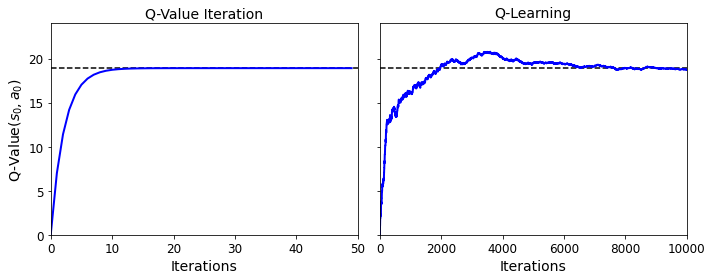

In [56]:
true_Q_value = history1[-1, 0, 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-Value$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-Value Iteration", fontsize=14)
axes[1].set_title("Q-Learning", fontsize=14)
for ax, width, history in zip(axes, (50, 10000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
    ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2)
    ax.set_xlabel("Iterations", fontsize=14)
    ax.axis([0, width, 0, 24])

save_fig("q_value_plot")

Figure 18-9. The Q-Value Iteration algorithm (left) versus the Q-Learning algorithm (right)

This algorithm will converge to the optimal Q-Values, but it will take many iterations, and possibly quite a lot of hyperparameter tuning. As you can see in Figure 18-9, the Q-Value Iteration algorithm (left) converges very quickly, in fewer than 20 iterations, while the Q-Learning algorithm (right) takes about 8,000 iterations to converge. Obviously, not knowing the transition probabilities or the rewards makes finding the optimal policy significantly harder! 


The Q-Learning algorithm is called an *off-policy* algorithm because the policy being trained is not necessarily the one being executed: in the previous code example, the policy being executed (the exploration policy) is completely random, while the policy being trained will always choose the actions with the highest Q-Values. Conversely, the Policy Gradients algorithm is an *on-policy* algorithm: it explores the world using the policy being trained. It is somewhat surprising that Q-Learning is capable of learning the optimal policy by just watching an agent act randomly (imagine learning to play golf when your teacher is a drunk monkey). Can we do better?

###  Exploration Policies  

Of course, Q-Learning can work only if the exploration policy explores the **Markov decision processes (MDPs)** thoroughly enough. Although a purely random policy is guaranteed to eventually visit every state and every transition many times, it may take an extremely long time to do so. Therefore, a better option is to use the $\epsilon$*-greedy policy* ($\epsilon$ is epsilon): at each step it acts randomly with probability $\epsilon$, or greedily with probability $1-\epsilon$ (i.e., choosing the action with the highest Q-Value). The advantage of the $\epsilon$-*greedy policy* (compared to a *completely random policy*) is that it will spend more and more time exploring the interesting parts of the environment, as the Q-Value estimates get better and better, while still spending some time visiting unknown regions of the MDP. It is quite common to start with a high value for $\epsilon$ (e.g., 1.0) and then gradually reduce it (e.g., down to 0.05).

Alternatively, rather than relying only on chance for exploration, another approach is to encourage the exploration policy to try actions that it has not tried much before. This can be implemented as a bonus added to the Q-Value estimates, as shown in Equation 18-6.

Equation 18-6. Q-Learning using an exploration function  

$$Q(s,a)\underset{\alpha}{\gets}r+\gamma\cdot\max_{a'} f\left(Q(s',a'), N(s',a')\right)$$
In this equation:

  - $N(s', a')$ counts the number of times the action $a'$ was chosen in state $s'$.

  - $f(Q, N)$ is an *exploration function*, such as $f(Q, N) = Q + \kappa/(1 + N)$, where $\kappa$ is a curiosity hyperparameter that measures how much the agent is attracted to the unknown.


###  Approximate Q-Learning and Deep Q-Learning  

The main problem with Q-Learning is that it does not scale well to large (or even medium) MDPs with many states and actions. For example, suppose you wanted to use Q-Learning to train an agent to play *Ms. Pac-Man* (see Figure 18-1). There are about 150 pellets that *Ms. Pac-Man* can eat, each of which can be present or absent (i.e., already eaten). So, the number of possible states is greater than $2^{150} \approx 10^{45}$. And if you add all the possible combinations of positions for all the ghosts and *Ms. Pac-Man*, the number of possible states becomes larger than the number of atoms in our planet, so there’s absolutely no way you can keep track of an estimate for every single Q-Value.

The solution is to find a function $Q_{\theta}(s, a)$ that approximates the Q-Value of any state-action pair $(s, a)$ using a manageable number of parameters (given by the parameter vector $\theta$). This is called *Approximate Q-Learning*. For years it was recommended to use linear combinations of handcrafted features extracted from the state (e.g., distance of the closest ghosts, their directions, and so on) to estimate Q-Values, but in 2013, DeepMind showed that using deep neural networks can work much better, especially for complex problems, and it does not require any feature engineering. A DNN used to estimate Q-Values is called a *Deep Q-Network (DQN)*, and using a DQN for Approximate Q-Learning is called *Deep Q-Learning*.

Now, how can we train a DQN? Well, consider the approximate Q-Value computed by the DQN for a given state-action pair $(s, a)$. Thanks to Bellman, we know we want this approximate Q-Value to be as close as possible to the reward $r$ that we actually observe after playing action a in state $s$, plus the discounted value of playing optimally from then on. To estimate this sum of future discounted rewards, we can simply execute the DQN on the next state $s'$ and for all possible actions $a'$. We get an approximate future Q-Value for each possible action. We then pick the highest (since we assume we will be playing optimally) and discount it, and this gives us an estimate of the sum of future discounted rewards. By summing the reward $r$ and the future discounted value estimate, we get a target Q-Value $y(s, a)$ for the state-action pair $(s, a)$, as shown in Equation 18-7.

Equation 18-7. Target Q-Value

$$Q_{target}(s,a)=r+\gamma\cdot\max_{a'} Q_{\theta}(s',a')$$
With this target Q-Value, we can run a training step using any Gradient Descent algorithm. Specifically, we generally try to minimize the squared error between the estimated Q-Value $Q(s, a)$ and the target Q-Value (or the Huber loss to reduce the algorithm’s sensitivity to large errors). And that’s all for the basic Deep Q-Learning algorithm! Let’s see how to implement it to solve the CartPole environment.



## Deep Q-Network  

The first thing we need is a Deep Q-Network. In theory, you need a neural net that takes a state-action pair and outputs an approximate Q-Value, but in practice it’s much more efficient to use a neural net that takes a state and outputs one approximate Q-Value for each possible action. To solve the CartPole environment, we do not need a very complicated neural net; a couple of hidden layers will do:

Let's build the DQN. Given a state, it will estimate, for each possible action, the sum of discounted future rewards it can expect after it plays that action (but before it sees its outcome):

In [57]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

env = gym.make("CartPole-v1")
input_shape = [4] # == env.observation_space.shape
n_outputs = 2 # == env.action_space.n

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

To select an action using this DQN, we just pick the action with the largest predicted Q-value. However, to ensure that the agent explores the environment, we choose a random action with probability `epsilon`.

In [58]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

Instead of training the DQN based only on the latest experiences, we will store all experiences in a *replay buffer* (or *replay memory*), and we will sample a random training batch from it at each training iteration. This helps reduce the correlations between the experiences in a training batch, which tremendously helps training. For this, we will just use a deque list:

We will also need a *replay memory*. It will contain the agent's experiences, in the form of tuples: `(obs, action, reward, next_obs, done)`. We can use the `deque` class for that (but make sure to check out DeepMind's excellent [Reverb library](https://github.com/deepmind/reverb) for a much more robust implementation of experience replay):

In [59]:
from collections import deque

replay_memory = deque(maxlen=2000)

TIP  

A *deque* is a linked list, where each element points to the next one and to the previous one. It makes inserting and deleting items very fast, but the longer the deque is, the slower random access will be. If you need a very large replay buffer, use a circular buffer;

Each experience will be composed of five elements: a state, the action the agent took, the resulting reward, the next state it reached, and finally a Boolean indicating whether the episode ended at that point (`done`). We will need a small function to sample a random batch of experiences from the replay buffer. It will return five NumPy arrays corresponding to the five experience elements:  

And let's create a function to sample experiences from the replay memory. It will return 5 NumPy arrays: `[obs, actions, rewards, next_obs, dones]`.

In [60]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

Now we can create a function that will use the DQN to play one step, and record its experience in the replay memory:

In [61]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

Lastly, let's create a function that will sample some experiences from the replay memory and perform a training step:

**Notes**:
* The first 3 releases of the 2nd edition were missing the `reshape()` operation which converts `target_Q_values` to a column vector (this is required by the `loss_fn()`).
* The book uses a learning rate of 1e-3, but in the code below I use 1e-2, as it significantly improves training. I also tuned the learning rates of the DQN variants below.

In [62]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards +
                       (1 - dones) * discount_rate * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

Let’s go through this code:

  - First we define some hyperparameters, and we create the optimizer and the loss function.

  - Then we create the `training_step()` function. It starts by sampling a batch of experiences, then it uses the DQN to predict the Q-Value for each possible action in each experience’s next state. Since we assume that the agent will be playing optimally, we only keep the maximum Q-Value for each next state. Next, we use Equation 18-7 to compute the target Q-Value for each experience’s state-action pair.
  - Equation 18-7. Target Q-Value

$$Q_{target}(s,a)=r+\gamma\cdot\max_{a'} Q_{\theta}(s',a')$$

  - Next, we want to use the DQN to compute the Q-Value for each experienced state-action pair. However, the DQN will also output the Q-Values for the other possible actions, not just for the action that was actually chosen by the agent. So we need to mask out all the Q-Values we do not need. The `tf.one_hot()` function makes it easy to convert an array of action indices into such a mask. For example, if the first three experiences contain actions 1, 1, 0, respectively, then the mask will start with `[[0, 1], [0, 1], [1, 0],...]`. We can then multiply the DQN’s output with this mask, and this will zero out all the Q-Values we do not want. We then sum over axis 1 to get rid of all the zeros, keeping only the Q-Values of the experienced state-action pairs. This gives us the `Q_values` tensor, containing one predicted Q-Value for each experience in the batch.

  - Then we compute the loss: it is the mean squared error between the target and predicted Q-Values for the experienced state-action pairs.

  - Finally, we perform a Gradient Descent step to minimize the loss with regard to the model’s trainable variables.

And now, let's train the model!

In [63]:
#env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = [] 
best_score = 0

In [64]:
for episode in range(600):
    obs = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step) # Not shown in the book
    if step >= best_score: # Not shown
        best_weights = model.get_weights() # Not shown
        best_score = step # Not shown
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="") # Not shown
    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)

Episode: 599, Steps: 200, eps: 0.010

We run 600 episodes, each for a maximum of 200 steps. At each step, we first compute the `epsilon` value for the $\epsilon$-greedy policy: it will go from 1 down to 0.01, linearly, in a bit under 500 episodes. Then we call the `play_one_step()` function, which will use the $\epsilon$-greedy policy to pick an action, then execute it and record the experience in the replay buffer. If the episode is done, we exit the loop. Finally, if we are past the 50th episode, we call the `training_step()` function to train the model on one batch sampled from the replay buffer. The reason we play 50 episodes without training is to give the replay buffer some time to fill up (if we don’t wait enough, then there will not be enough diversity in the replay buffer). And that’s it, we just implemented the Deep Q-Learning algorithm!

Figure 18-10 shows the total rewards the agent got during each episode.

Saving figure dqn_rewards_plot


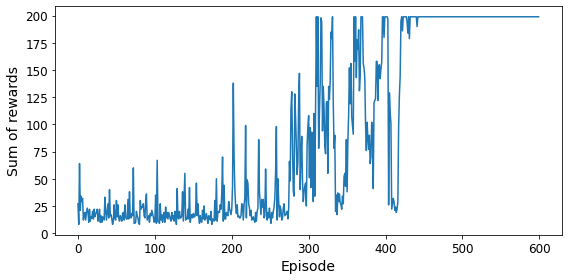

In [65]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
save_fig("dqn_rewards_plot")
plt.show()

Figure 18-10. Learning curve of the Deep Q-Learning algorithm

As you can see, the algorithm made no apparent progress at all for almost 300 episodes (in part because $\epsilon$ was very high at the beginning), then its performance suddenly skyrocketed up to 200 (which is the maximum possible performance in this environment). That’s great news: the algorithm worked fine, and it actually ran much faster than the Policy Gradient algorithm! But wait… just a few episodes later, it forgot everything it knew, and its performance dropped below 25! This is called *catastrophic forgetting*, and it is one of the big problems facing virtually all RL algorithms: as the agent explores the environment, it updates its policy, but what it learns in one part of the environment may break what it learned earlier in other parts of the environment. The experiences are quite correlated, and the learning environment keeps changing—this is not ideal for Gradient Descent! If you increase the size of the replay buffer, the algorithm will be less subject to this problem. Reducing the learning rate may also help. But the truth is, Reinforcement Learning is hard: training is often unstable, and you may need to try many hyperparameter values and random seeds before you find a combination that works well. For example, if you try changing the number of neurons per layer in the preceding from 32 to 30 or 34, the performance will never go above 100 (the DQN may be more stable with one hidden layer instead of two).  

You might wonder why we didn’t plot the loss. It turns out that loss is a poor indicator of the model’s performance. The loss might go down, yet the agent might perform worse (e.g., this can happen when the agent gets stuck in one small region of the environment, and the DQN starts overfitting this region). Conversely, the loss could go up, yet the agent might perform better (e.g., if the DQN was underestimating the Q-Values, and it starts correctly increasing its predictions, the agent will likely perform better, getting more rewards, but the loss might increase because the DQN also sets the targets, which will be larger too).

The basic Deep Q-Learning algorithm we’ve been using so far would be too unstable to learn to play Atari games. So how did DeepMind do it? Well, they tweaked the algorithm!

In [66]:
env.seed(42)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)

C:\Users\lidan\miniconda3\lib\site-packages\gym\core.py:172: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  deprecation(


Not bad at all! 😀

## Deep Q-Learning Variants  

Let’s look at a few variants of the Deep Q-Learning algorithm that can stabilize and speed up training.

### Fixed Q-Value Targets  

In the basic Deep Q-Learning algorithm, the model is used both to make predictions and to set its own targets. This can lead to a situation analogous to a dog chasing its own tail. This feedback loop can make the network unstable: it can diverge, oscillate, freeze, and so on. To solve this problem, in their 2013 paper the DeepMind researchers used two DQNs instead of one: the first is the *online model*, which learns at each step and is used to move the agent around, and the other is the target model used only to define the targets. The *target model* is just a clone of the online model:

In [ ]:
target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

Then, in the `training_step()` function, we just need to change one line to use the target model instead of the online model when computing the Q-Values of the next states:

In [ ]:
next_Q_values = target.predict(next_states)

Finally, in the training loop, we must copy the weights of the online model to the target model, at regular intervals (e.g., every 50 episodes):

In [ ]:
if episode % 50 == 0:
    target.set_weights(model.get_weights())

Since the target model is updated much less often than the online model, the Q-Value targets are more stable, the feedback loop we discussed earlier is dampened, and its effects are less severe. This approach was one of the DeepMind researchers’ main contributions in their 2013 paper, allowing agents to learn to play Atari games from raw pixels. To stabilize training, they used a tiny learning rate of 0.00025, they updated the target model only every 10,000 steps (instead of the 50 in the previous code example), and they used a very large replay buffer of 1 million experiences. They decreased epsilon very slowly, from 1 to 0.1 in 1 million steps, and they let the algorithm run for 50 million steps.

Later in this chapter, we will use the TF-Agents library to train a DQN agent to play Breakout using these hyperparameters, but before we get there, let’s take a look at another DQN variant that managed to beat the state of the art once more.

### Double DQN  

In a 2015 paper, DeepMind researchers tweaked their DQN algorithm, increasing its performance and somewhat stabilizing training. They called this variant Double DQN. The update was based on the observation that the target network is prone to overestimating Q-Values. Indeed, suppose all actions are equally good: the Q-Values estimated by the target model should be identical, but since they are approximations, some may be slightly greater than others, by pure chance. The target model will always select the largest Q-Value, which will be slightly greater than the mean Q-Value, most likely overestimating the true Q-Value (a bit like counting the height of the tallest random wave when measuring the depth of a pool). To fix this, they proposed using the online model instead of the target model when selecting the best actions for the next states, and using the target model only to estimate the Q-Values for these best actions. Here is the updated `training_step()` function:

In [44]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

n_outputs = 2

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=[4]),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [45]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(learning_rate=6e-3)
loss_fn = keras.losses.Huber()

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target.predict(next_states) * next_mask).sum(axis=1)
    target_Q_values = (rewards + 
                       (1 - dones) * discount_rate * next_best_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [47]:
from collections import deque
replay_memory = deque(maxlen=2000)

In [55]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

In [56]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

In [57]:
#env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = []
best_score = 0

for episode in range(600):
    obs = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="")
    if episode >= 50:
        training_step(batch_size)
        if episode % 50 == 0:
            target.set_weights(model.get_weights())
    # Alternatively, you can do soft updates at each step:
    #if episode >= 50:
        #target_weights = target.get_weights()
        #online_weights = model.get_weights()
        #for index in range(len(target_weights)):
        #    target_weights[index] = 0.99 * target_weights[index] + 0.01 * online_weights[index]
        #target.set_weights(target_weights)

model.set_weights(best_weights)

Episode: 599, Steps: 75, eps: 0.0100

Saving figure double_dqn_rewards_plot


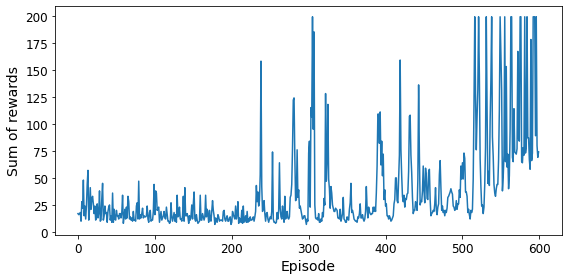

In [58]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
save_fig("double_dqn_rewards_plot")
plt.show()

In [59]:
env.seed(43)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
   
plot_animation(frames)

Just a few months later, another improvement to the DQN algorithm was proposed.

###  Prioritized Experience Replay  

Instead of sampling experiences *uniformly* from the replay buffer, why not sample important experiences more frequently? This idea is called *importance sampling (IS)* or *prioritized experience replay (PER)*, and it was introduced in a 2015 paper by DeepMind researchers.

More specifically, experiences are considered “important” if they are likely to lead to fast learning progress. But how can we estimate this? One reasonable approach is to measure the magnitude of the TD error $\delta = r + \gamma\cdot V(s') - V(s)$. A large **Temporal Difference (TD)** error indicates that a transition $(s, r, s')$ is very surprising, and thus probably worth learning from. When an experience is recorded in the replay buffer, its priority is set to a very large value, to ensure that it gets sampled at least once. However, once it is sampled (and every time it is sampled), the TD error $\delta$ is computed, and this experience’s priority is set to $p = |\delta|$ (plus a small constant to ensure that every experience has a non-zero probability of being sampled). The probability $P$ of sampling an experience with priority $p$ is proportional to $p^{\zeta}$, where $\zeta$ is a hyperparameter that controls how greedy we want importance sampling to be: when $\zeta = 0$, we just get uniform sampling, and when $\zeta = 1$, we get full-blown importance sampling. In the paper, the authors used $\zeta = 0.6$, but the optimal value will depend on the task.

There’s one catch, though: since the samples will be biased toward important experiences, we must compensate for this bias during training by downweighting the experiences according to their importance, or else the model will just overfit the important experiences. To be clear, we want important experiences to be sampled more often, but this also means we must give them a lower weight during training. To do this, we define each experience’s training weight as $w = (n P)^{-\beta}$, where $n$ is the number of experiences in the replay buffer, and $\beta$ is a hyperparameter that controls how much we want to compensate for the importance sampling bias (0 means not at all, while 1 means entirely). In the paper, the authors used $\beta = 0.4$ at the beginning of training and linearly increased it to $\beta = 1$ by the end of training. Again, the optimal value will depend on the task, but if you increase one, you will usually want to increase the other as well.

Now let’s look at one last important variant of the DQN algorithm.

### Dueling DQN  

The *Dueling DQN algorithm* (DDQN, not to be confused with Double DQN, although both techniques can easily be combined) was introduced in yet another 2015 paper by DeepMind researchers. To understand how it works, we must first note that the Q-Value of a state-action pair $(s, a)$ can be expressed as $Q(s, a) = V(s) + A(s, a)$, where $V(s)$ is the value of state $s$ and $A(s, a)$ is the advantage of taking the action a in state $s$, compared to all other possible actions in that state. Moreover, the value of a state is equal to the Q-Value of the best action $a^*$ for that state (since we assume the optimal policy will pick the best action), so $V(s) = Q(s, a^*)$, which implies that $A(s, a^*) = 0$. In a Dueling DQN, the model estimates both the value of the state and the advantage of each possible action. Since the best action should have an advantage of 0, the model subtracts the maximum predicted advantage from all predicted advantages. Here is a simple Dueling DQN model, implemented using the Functional API:

In [ ]:
K = keras.backend
input_states = keras.layers.Input(shape=[4])
hidden1 = keras.layers.Dense(32, activation="elu")(input_states)
hidden2 = keras.layers.Dense(32, activation="elu")(hidden1)
state_values = keras.layers.Dense(1)(hidden2)
raw_advantages = keras.layers.Dense(n_outputs)(hidden2)
advantages = raw_advantages - K.max(raw_advantages, axis=1, keepdims=True)
Q_values = state_values + advantages
model = keras.Model(inputs=[input_states], outputs=[Q_values])

###  Double Dueling DQN

The rest of the algorithm is just the same as earlier. In fact, you can build a Double Dueling DQN and combine it with prioritized experience replay! More generally, many RL techniques can be combined, as DeepMind demonstrated in a 2017 paper. The paper’s authors combined six different techniques into an agent called *Rainbow*, which largely outperformed the state of the art.


In [60]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

K = keras.backend
input_states = keras.layers.Input(shape=[4])
hidden1 = keras.layers.Dense(32, activation="elu")(input_states)
hidden2 = keras.layers.Dense(32, activation="elu")(hidden1)
state_values = keras.layers.Dense(1)(hidden2)
raw_advantages = keras.layers.Dense(n_outputs)(hidden2)
advantages = raw_advantages - K.max(raw_advantages, axis=1, keepdims=True)
Q_values = state_values + advantages
model = keras.models.Model(inputs=[input_states], outputs=[Q_values])

target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [61]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(learning_rate=7.5e-3)
loss_fn = keras.losses.Huber()

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target.predict(next_states) * next_mask).sum(axis=1)
    target_Q_values = (rewards + 
                       (1 - dones) * discount_rate * next_best_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [62]:
replay_memory = deque(maxlen=2000)

In [63]:
#env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = []
best_score = 0

for episode in range(600):
    obs = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="")
    if episode >= 50:
        training_step(batch_size)
        if episode % 50 == 0:
            target.set_weights(model.get_weights())

model.set_weights(best_weights)

Episode: 599, Steps: 41, eps: 0.0100

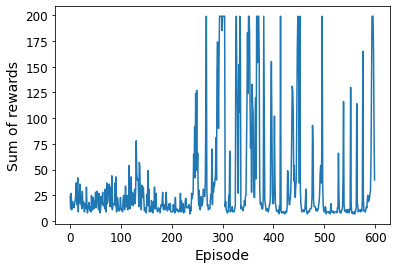

In [64]:
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Sum of rewards")
plt.show()

In [65]:
#env.seed(42)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)

This looks like a pretty robust agent!

In [79]:
env.close()

Unfortunately, implementing all of these techniques, debugging them, fine-tuning them, and of course training the models can require a huge amount of work. So instead of reinventing the wheel, it is often best to reuse scalable and well-tested libraries, such as TF-Agents.

## Using TF-Agents to Beat Breakout  

The TF-Agents library is a Reinforcement Learning library based on TensorFlow, developed at Google and open sourced in 2018. Just like OpenAI Gym, it provides many off-the-shelf environments (including wrappers for all OpenAI Gym environments), plus it supports the PyBullet library (for 3D physics simulation), DeepMind’s DM Control library (based on MuJoCo’s physics engine), and Unity’s ML-Agents library (simulating many 3D environments). It also implements many RL algorithms, including REINFORCE, DQN, and DDQN, as well as various RL components such as efficient replay buffers and metrics. It is fast, scalable, easy to use, and customizable: you can create your own environments and neural nets, and you can customize pretty much any component. In this section we will use TF-Agents to train an agent to play Breakout, the famous Atari game (see Figure 18-1119), using the DQN algorithm (you can easily switch to another algorithm if you prefer).

Let's use TF-Agents to create an agent that will learn to play Breakout. We will use the Deep Q-Learning algorithm, so you can easily compare the components with the previous implementation, but TF-Agents implements many other (and more sophisticated) algorithms!

### TF-Agents Environments 

If everything went well, you should be able to import TF-Agents and create a Breakout environment:

In [2]:
tf.random.set_seed(42)
np.random.seed(42)

In [3]:
import atari_py
print(atari_py.list_games())

['tetris']


In [4]:
from tf_agents.environments import suite_gym

env = suite_gym.load("Breakout-v4")
env

This is just a wrapper around an OpenAI Gym environment, which you can access through the `gym` attribute:

In [5]:
env.gym

<TimeLimit<OrderEnforcing<AtariEnv<Breakout-v4>>>>

TF-Agents environments are very similar to OpenAI Gym environments, but there are a few differences. First, the `reset()` method does not return an observation; instead it returns a `TimeStep` object that wraps the observation, as well as some extra information:

In [6]:
#env.seed(42)
env.reset()

TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8),
 'reward': array(0., dtype=float32),
 'step_type': array(0)})

In [12]:
env.reset().discount, env.reset().observation.shape, env.reset().reward, env.reset().step_type,

(array(1., dtype=float32), (210, 160, 3), array(0., dtype=float32), array(0))

The `step()` method returns a `TimeStep` object as well:

In [13]:
env.step(1) # Fire

TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8),
 'reward': array(0., dtype=float32),
 'step_type': array(1)})

Saving figure breakout_plot


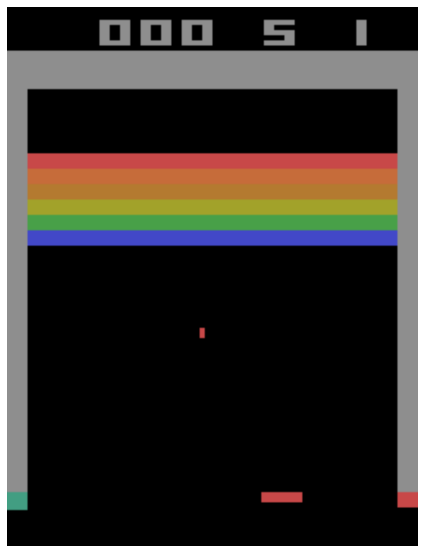

In [14]:
img = env.render(mode="rgb_array")

plt.figure(figsize=(6, 8))
plt.imshow(img)
plt.axis("off")
save_fig("breakout_plot")
plt.show()

Figure 18-11. The famous Breakout game

In [87]:
env.current_time_step()

TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8),
 'reward': array(0., dtype=float32),
 'step_type': array(1)})

In [15]:
env.current_time_step().discount, env.current_time_step().observation.shape, env.current_time_step().reward, env.current_time_step().step_type,

(array(1., dtype=float32), (210, 160, 3), array(0., dtype=float32), array(1))

The `reward` and `observation` attributes are self-explanatory, and they are the same as for OpenAI Gym (except the reward is represented as a NumPy array). The `step_type` attribute is equal to `0` for the first time step in the episode, `1` for intermediate time steps, and `2` for the final time step. You can call the time step’s `is_last()` method to check whether it is the final one or not. Lastly, the discount attribute indicates the `discount` factor to use at this time step. In this example it is equal to `1`, so there will be no discount at all. You can define the discount factor by setting the `discount` parameter when loading the environment.

### Environment Specifications  

Conveniently, a TF-Agents environment provides the specifications of the observations, actions, and time steps, including their shapes, data types, and names, as well as their minimum and maximum values:

In [16]:
env.observation_spec()

BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255)

In [17]:
env.action_spec()

BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=3)

In [18]:
env.time_step_spec()

TimeStep(
{'discount': BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0),
 'observation': BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255),
 'reward': ArraySpec(shape=(), dtype=dtype('float32'), name='reward'),
 'step_type': ArraySpec(shape=(), dtype=dtype('int32'), name='step_type')})

As you can see, the observations are simply screenshots of the Atari screen, represented as NumPy arrays of shape [210, 160, 3]. To render an environment, you can call `env.render(mode="human")`, and if you want to get back the image in the form of a NumPy array, just call `env.render(mode="rgb_array")` (unlike in OpenAI Gym, this is the default mode).

There are four actions available. Gym’s Atari environments have an extra method that you can call to know what each action corresponds to:

In [19]:
env.gym.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT']

The observations are quite large, so we will downsample them and also convert them to grayscale. This will speed up training and use less RAM. For this, we can use an *environment wrapper*.

### Environment Wrappers and Atari Preprocessing  

TF-Agents provides several environment wrappers in the `tf_agents.environments.wrappers` package. As their name suggests, they wrap an environment, forwarding every call to it, but also adding some extra functionality. Here are some of the available wrappers:

*ActionClipWrapper* 

  - Clips the actions to the action spec.

*ActionDiscretizeWrapper* 

  - Quantizes a continuous action space to a discrete action space. For example, if the original environment’s action space is the continuous range from –1.0 to +1.0, but you want to use an algorithm that only supports discrete action spaces, such as a DQN, then you can wrap the environment using `discrete_env = ActionDiscretizeWrapper(env, num_actions=5)`, and the new `discrete_env` will have a discrete action space with five possible actions: 0, 1, 2, 3, 4. These actions correspond to the actions –1.0, –0.5, 0.0, 0.5, and 1.0 in the original environment.

*ActionRepeat*

  - Repeats each action over n steps, while accumulating the rewards. In many environments, this can speed up training significantly.

*RunStats*

  - Records environment statistics such as the number of steps and the number of episodes.

*TimeLimit*

  - Interrupts the environment if it runs for longer than a maximum number of steps.

*VideoWrapper*

  - Records a video of the environment.

To create a wrapped environment, you must create a wrapper, passing the wrapped environment to the constructor. That’s all! For example, the following code will wrap our environment in an `ActionRepeat` wrapper so that every action is repeated four times:

In [91]:
from tf_agents.environments.wrappers import ActionRepeat

repeating_env = ActionRepeat(env, times=4)
repeating_env

In [92]:
repeating_env.unwrapped

Here is the list of available wrappers:

In [93]:
import tf_agents.environments.wrappers

for name in dir(tf_agents.environments.wrappers):
    obj = getattr(tf_agents.environments.wrappers, name)
    if hasattr(obj, "__base__") and issubclass(obj, tf_agents.environments.wrappers.PyEnvironmentBaseWrapper):
        print("{:27s} {}".format(name, obj.__doc__.split("\n")[0]))

ActionClipWrapper           Wraps an environment and clips actions to spec before applying.
ActionDiscretizeWrapper     Wraps an environment with continuous actions and discretizes them.
ActionOffsetWrapper         Offsets actions to be zero-based.
ActionRepeat                Repeates actions over n-steps while acummulating the received reward.
ExtraDisabledActionsWrapper Adds extra unavailable actions.
FixedLength                 Truncates long episodes and pads short episodes to have a fixed length.
FlattenActionWrapper        Flattens the action.
FlattenObservationsWrapper  Wraps an environment and flattens nested multi-dimensional observations.
GoalReplayEnvWrapper        Adds a goal to the observation, used for HER (Hindsight Experience Replay).
HistoryWrapper              Adds observation and action history to the environment's observations.
ObservationFilterWrapper    Filters observations based on an array of indexes.
OneHotActionWrapper         Converts discrete action to one_h

OpenAI Gym has some environment wrappers of its own in the `gym.wrappers` package. They are meant to wrap Gym environments, though, not TF-Agents environments, so to use them you must first wrap the Gym environment with a Gym wrapper, then wrap the resulting environment with a TF-Agents wrapper. The `suite_gym.wrap_env()` function will do this for you, provided you give it a Gym environment and a list of Gym wrappers and/or a list of TF-Agents wrappers. Alternatively, the `suite_gym.load()` function will both create the Gym environment and wrap it for you, if you give it some wrappers. Each wrapper will be created without any arguments, so if you want to set some arguments, you must pass a `lambda`. For example, the following code creates a Breakout environment that will run for a maximum of 10,000 steps during each episode, and each action will be repeated four times:

The `suite_gym.load()` function can create an env and wrap it for you, both with TF-Agents environment wrappers and Gym environment wrappers (the latter are applied first).

In [94]:
from functools import partial
from gym.wrappers import TimeLimit

limited_repeating_env = suite_gym.load(
    "Breakout-v4",
    gym_env_wrappers=[partial(TimeLimit, max_episode_steps=10000)],
    env_wrappers=[partial(ActionRepeat, times=4)],
)

In [95]:
limited_repeating_env

In [96]:
limited_repeating_env.unwrapped

For Atari environments, some standard preprocessing steps are applied in most papers that use them, so TF-Agents provides a handy `AtariPreprocessing` wrapper that implements them. Here is the list of preprocessing steps it supports:

*Grayscale and downsampling* 

  - Observations are converted to grayscale and downsampled (by default to 84 × 84 pixels).

*Max pooling* 

  - The last two frames of the game are max-pooled using a 1 × 1 filter. This is to remove the flickering that occurs in some Atari games due to the limited number of sprites that the Atari 2600 could display in each frame.

*Frame skipping* 

  - The agent only gets to see every n frames of the game (by default n = 4), and its actions are repeated for each frame, collecting all the rewards. This effectively speeds up the game from the perspective of the agent, and it also speeds up training because rewards are less delayed.

*End on life lost* 

  - In some games, the rewards are just based on the score, so the agent gets no immediate penalty for losing a life. One solution is to end the game immediately whenever a life is lost. There is some debate over the actual benefits of this strategy, so it is off by default.

Since the default Atari environment already applies random frame skipping and max pooling, we will need to load the raw, nonskipping variant called "`BreakoutNoFrameskip-v4`". Moreover, a single frame from the *Breakout* game is insufficient to know the direction and speed of the ball, which will make it very difficult for the agent to play the game properly (unless it is an RNN agent, which preserves some internal state between steps). One way to handle this is to use an environment wrapper that will output observations composed of multiple frames stacked on top of each other along the channels dimension. This strategy is implemented by the `FrameStack4` wrapper, which returns stacks of four frames. Let’s create the wrapped Atari environment!

Create an Atari Breakout environment, and wrap it to apply the default Atari preprocessing steps:

**Warning**: Breakout requires the player to press the FIRE button at the start of the game and after each life lost. The agent may take a very long time learning this because at first it seems that pressing FIRE just means losing faster. To speed up training considerably, we create and use a subclass of the `AtariPreprocessing` wrapper class called `AtariPreprocessingWithAutoFire` which presses FIRE (i.e., plays action 1) automatically at the start of the game and after each life lost. This is different from the book which uses the regular `AtariPreprocessing` wrapper.

In [97]:
from tf_agents.environments import suite_atari
from tf_agents.environments.atari_preprocessing import AtariPreprocessing
from tf_agents.environments.atari_wrappers import FrameStack4

max_episode_steps = 27000 # <=> 108k ALE frames since 1 step = 4 frames
environment_name = "BreakoutNoFrameskip-v4"

class AtariPreprocessingWithAutoFire(AtariPreprocessing):
    def reset(self, **kwargs):
        obs = super().reset(**kwargs)
        super().step(1) # FIRE to start
        return obs
    def step(self, action):
        lives_before_action = self.ale.lives()
        obs, rewards, done, info = super().step(action)
        if self.ale.lives() < lives_before_action and not done:
            super().step(1) # FIRE to start after life lost
        return obs, rewards, done, info

env = suite_atari.load(
    environment_name,
    max_episode_steps=max_episode_steps,
    gym_env_wrappers=[AtariPreprocessingWithAutoFire, FrameStack4])

In [98]:
env

Play a few steps just to see what happens:

In [99]:
env.seed(42)
env.reset()
for _ in range(4):
    time_step = env.step(3) # LEFT

In [100]:
def plot_observation(obs):
    # Since there are only 3 color channels, you cannot display 4 frames
    # with one primary color per frame. So this code computes the delta between
    # the current frame and the mean of the other frames, and it adds this delta
    # to the red and blue channels to get a pink color for the current frame.
    obs = obs.astype(np.float32)
    img = obs[..., :3]
    current_frame_delta = np.maximum(obs[..., 3] - obs[..., :3].mean(axis=-1), 0.)
    img[..., 0] += current_frame_delta
    img[..., 2] += current_frame_delta
    img = np.clip(img / 150, 0, 1)
    plt.imshow(img)
    plt.axis("off")

Saving figure preprocessed_breakout_plot


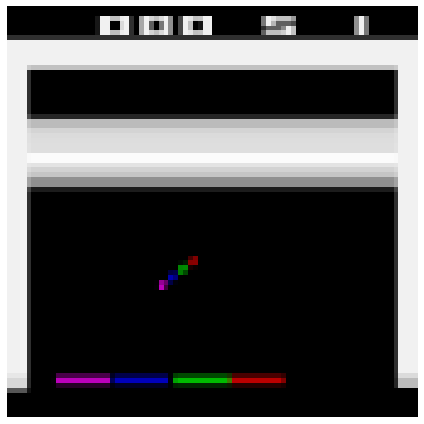

In [101]:
plt.figure(figsize=(6, 6))
plot_observation(time_step.observation)
save_fig("preprocessed_breakout_plot")
plt.show()

Figure 18-12. Preprocessed Breakout observation  

The result of all this preprocessing is shown in Figure 18-12. You can see that the resolution is much lower, but sufficient to play the game. Moreover, frames are stacked along the channels dimension, so red represents the frame from three steps ago, green is two steps ago, blue is the previous frame, and pink is the current frame. From this single observation, the agent can see that the ball is going toward the lower-left corner, and that it should continue to move the paddle to the left (as it did in the previous steps).

Lastly, we can wrap the environment inside a `TFPyEnvironment`:

In [102]:
from tf_agents.environments.tf_py_environment import TFPyEnvironment

tf_env = TFPyEnvironment(env)

This will make the environment usable from within a TensorFlow graph (under the hood, this class relies on `tf.py_function()`, which allows a graph to call arbitrary Python code). Thanks to the `TFPyEnvironment` class, TF-Agents supports both pure Python environments and TensorFlow-based environments. More generally, TF-Agents supports and provides both pure Python and TensorFlow-based components (agents, replay buffers, metrics, and so on).

Now that we have a nice Breakout environment, with all the appropriate preprocessing and TensorFlow support, we must create the DQN agent and the other components we will need to train it. Let’s look at the architecture of the system we will build.

###  Training Architecture  

A TF-Agents training program is usually split into two parts that run in parallel, as you can see in Figure 18-13: on the left, a driver explores the *environment* using a *collect policy* to choose actions, and it collects trajectories (i.e., experiences), sending them to an observer, which saves them to a replay buffer; on the right, an agent pulls batches of trajectories from the *replay buffer* and trains some networks, which the collect policy uses. In short, the left part explores the environment and collects trajectories, while the right part learns and updates the collect policy.

<img src="./chapters/18/18-13.png">
<div style="text-align:center"> Figure 18-13. A typical TF-Agents training architecture </div>   

This figure begs a few questions, which I’ll attempt to answer here:

  - Why are there multiple environments? Instead of exploring a single environment, you generally want the driver to explore multiple copies of the environment in parallel, taking advantage of the power of all your CPU cores, keeping the training GPUs busy, and providing less-correlated trajectories to the training algorithm.

  - What is a *trajectory*? It is a concise representation of a *transition* from one time step to the next, or a sequence of consecutive transitions from time step `n` to time step `n + t`. The trajectories collected by the driver are passed to the observer, which saves them in the replay buffer, and they are later sampled by the *agent* and used for training.

  - Why do we need an observer? Can’t the driver save the trajectories directly? Indeed, it could, but this would make the architecture less flexible. For example, what if you don’t want to use a replay buffer? What if you want to use the trajectories for something else, like computing metrics? In fact, an observer is just any function that takes a trajectory as an argument. You can use an observer to save the trajectories to a replay buffer, or to save them to a TFRecord file (see Chapter 13), or to compute metrics, or for anything else. Moreover, you can pass multiple observers to the driver, and it will broadcast the trajectories to all of them.  
  
TIP  


Although this architecture is the most common, you can customize it as you please, and even replace some components with your own. In fact, unless you are researching new RL algorithms, you will most likely want to use a custom environment for your task. For this, you just need to create a custom class that inherits from the `PyEnvironment` class in the `tf_agents.environments.py_environment` package and overrides the appropriate methods, such as `action_spec()`, `observation_spec()`, `_reset()`, and `_step()`   

Now we will create all these components: first the Deep Q-Network, then the DQN agent (which will take care of creating the collect policy), then the replay buffer and the observer to write to it, then a few training metrics, then the driver, and finally the dataset. Once we have all the components in place, we will populate the replay buffer with some initial trajectories, then we will run the main training loop. So, let’s start by creating the Deep Q-Network.

### Creating the Deep Q-Network DQN  

The TF-Agents library provides many networks in the `tf_agents.networks` package and its subpackages. We will use the `tf_agents.networks.q_network.QNetwork` class:

Create a small class to normalize the observations. Images are stored using bytes from 0 to 255 to use less RAM, but we want to pass floats from 0.0 to 1.0 to the neural network:

In [1]:
from tf_agents.environments import suite_atari
from tf_agents.environments.atari_preprocessing import AtariPreprocessing
from tf_agents.environments.atari_wrappers import FrameStack4

max_episode_steps = 27000 # <=> 108k ALE frames since 1 step = 4 frames
environment_name = "BreakoutNoFrameskip-v4"

class AtariPreprocessingWithAutoFire(AtariPreprocessing):
    def reset(self, **kwargs):
        obs = super().reset(**kwargs)
        super().step(1) # FIRE to start
        return obs
    def step(self, action):
        lives_before_action = self.ale.lives()
        obs, rewards, done, info = super().step(action)
        if self.ale.lives() < lives_before_action and not done:
            super().step(1) # FIRE to start after life lost
        return obs, rewards, done, info

env = suite_atari.load(
    environment_name,
    max_episode_steps=max_episode_steps,
    gym_env_wrappers=[AtariPreprocessingWithAutoFire, FrameStack4])

In [2]:
import tensorflow as tf
from tensorflow import keras
from tf_agents.environments.tf_py_environment import TFPyEnvironment

tf_env = TFPyEnvironment(env)

In [3]:
from tf_agents.networks.q_network import QNetwork

preprocessing_layer = keras.layers.Lambda(
                          lambda obs: tf.cast(obs, np.float32) / 255.)
conv_layer_params=[(32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1)]
fc_layer_params=[512]

q_net = QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    preprocessing_layers=preprocessing_layer,
    conv_layer_params=conv_layer_params,
    fc_layer_params=fc_layer_params)

This QNetwork takes an observation as input and outputs one Q-Value per action, so we must give it the specifications of the observations and the actions. It starts with a preprocessing layer: a simple `Lambda` layer that casts the observations to 32-bit floats and normalizes them (the values will range from 0.0 to 1.0). The observations contain unsigned bytes, which use 4 times less space than 32-bit floats, which is why we did not cast the observations to 32-bit floats earlier; we want to save RAM in the replay buffer. Next, the network applies three convolutional layers: the first has 32 8 × 8 filters and uses a stride of 4, the second has 64 4 × 4 filters and a stride of 2, and the third has 64 3 × 3 filters and a stride of 1. Lastly, it applies a `dense` layer with 512 units, followed by a `dense` output layer with 4 units, one per Q-Value to output (i.e., one per action). All convolutional layers and all dense layers except the output layer use the `ReLU` activation function by default (you can change this by setting the `activation_fn` argument). The output layer does not use any activation function.

Under the hood, a `QNetwork` is composed of two parts: an encoding network that processes the observations, followed by a dense output layer that outputs one Q-Value per action. TF-Agent’s `EncodingNetwork` class implements a neural network architecture found in various agents (see Figure 18-14).

It may have one or more inputs. For example, if each observation is composed of some sensor data plus an image from a camera, you will have two inputs. Each input may require some preprocessing steps, in which case you can specify a list of Keras layers via the `preprocessing_layers` argument, with one preprocessing layer per input, and the network will apply each layer to the corresponding input (if an input requires multiple layers of preprocessing, you can pass a whole model, since a Keras model can always be used as a layer). If there are two inputs or more, you must also pass an extra layer via the `preprocessing_combiner` argument, to combine the outputs from the preprocessing layers into a single output.

Next, the encoding network will optionally apply a list of convolutions sequentially, provided you specify their parameters via the `conv_layer_params` argument. This must be a list composed of 3-tuples (one per convolutional layer) indicating the number of filters, the kernel size, and the stride. After these convolutional layers, the encoding network will optionally apply a sequence of dense layers, if you set the `fc_layer_params` argument: it must be a list containing the number of neurons for each dense layer. Optionally, you can also pass a list of dropout rates (one per dense layer) via the `dropout_layer_params` argument if you want to apply dropout after each dense layer. The QNetwork takes the output of this encoding network and passes it to the dense output layer (with one unit per action).  

<img src="./chapters/18/18-14.png">
<div style="text-align:center"> Figure 18-14. Architecture of an encoding network </div>

###  Creating the DQN Agent  

The TF-Agents library implements many types of agents, located in the `tf_agents.agents` package and its subpackages. We will use the `tf_agents.agents.dqn.dqn_agent.DqnAgent` class:

In [5]:
from tf_agents.agents.dqn.dqn_agent import DqnAgent

train_step = tf.Variable(0)
update_period = 4 # run a training step every 4 collect steps
optimizer = keras.optimizers.RMSprop(learning_rate=2.5e-4, rho=0.95, momentum=0.0,
                                     epsilon=0.00001, centered=True)
epsilon_fn = keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1.0, # initial ε
    decay_steps=250000 // update_period, # <=> 1,000,000 ALE frames
    end_learning_rate=0.01) # final ε
agent = DqnAgent(tf_env.time_step_spec(),
                 tf_env.action_spec(),
                 q_network=q_net,
                 optimizer=optimizer,
                 target_update_period=2000, # <=> 32,000 ALE frames
                 td_errors_loss_fn=keras.losses.Huber(reduction="none"),
                 gamma=0.99, # discount factor
                 train_step_counter=train_step,
                 epsilon_greedy=lambda: epsilon_fn(train_step))
agent.initialize()

2022-05-20 17:38:23.187901: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Let’s walk through this code:

  - We first create a variable that will count the number of training steps.

  - Then we build the optimizer, using the same hyperparameters as in the 2015 DQN paper.

  - Next, we create a `PolynomialDecay` object that will compute the $\epsilon$ value for the $\epsilon$-greedy collect policy, given the current training step (it is normally used to decay the learning rate, hence the names of the arguments, but it will work just fine to decay any other value). It will go from 1.0 down to 0.01 (the value used during in the 2015 DQN paper) in 1 million ALE frames, which corresponds to 250,000 steps, since we use frame skipping with a period of 4. Moreover, we will train the agent every 4 steps (i.e., 16 ALE frames), so $\epsilon$ will actually decay over 62,500 training steps.

  - We then build the DQNAgent, passing it the time step and action specs, the QNetwork to train, the optimizer, the number of training steps between target model updates, the loss function to use, the discount factor, the `train_step` variable, and a function that returns the $\epsilon$ value (it must take no argument, which is why we need a lambda to pass the `train_step`).

    Note that the loss function must return an error per instance, not the mean error, which is why we set `reduction="none"`.

  - Lastly, we initialize the agent.

Next, let’s build the replay buffer and the observer that will write to it.

###  Creating the Replay Buffer and the Corresponding Observer  


The TF-Agents library provides various replay buffer implementations in the `tf_agents.replay_buffers` package. Some are purely written in Python (their module names start with `py_`), and others are written based on TensorFlow (their module names start with `tf_`). We will use the `TFUniformReplayBuffer` class in the `tf_agents.replay_buffers.tf_uniform_replay_buffer` package. It provides a high-performance implementation of a replay buffer with uniform sampling:

Create the replay buffer (this will use a lot of RAM, so please reduce the buffer size if you get an out-of-memory error):

**Warning**: we use a replay buffer of size 100,000 instead of 1,000,000 (as used in the book) since many people were getting OOM (Out-Of-Memory) errors.

In [6]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=100000) # reduce if OOM error

replay_buffer_observer = replay_buffer.add_batch

Let’s look at each of these arguments:

*data_spec* 

  - The specification of the data that will be saved in the replay buffer. The DQN agent knowns what the collected data will look like, and it makes the data spec available via its `collect_data_spec` attribute, so that’s what we give the replay buffer.

*batch_size*  

  - The number of trajectories that will be added at each step. In our case, it will be one, since the driver will just execute one action per step and collect one trajectory. If the environment were a batched environment, meaning an environment that takes a batch of actions at each step and returns a batch of observations, then the driver would have to save a batch of trajectories at each step. Since we are using a TensorFlow replay buffer, it needs to know the size of the batches it will handle (to build the computation graph). An example of a batched environment is the `ParallelPyEnvironment` (from the `tf_agents.environments.parallel_py_environment` package): it runs multiple environments in parallel in separate processes (they can be different as long as they have the same action and observation specs), and at each step it takes a batch of actions and executes them in the environments (one action per environment), then it returns all the resulting observations.

*max_length* 

  - The maximum size of the replay buffer. We created a large replay buffer that can store one million trajectories (as was done in the 2015 DQN paper). This will require a lot of RAM. 
  
Now we can create the observer that will write the trajectories to the replay buffer. An observer is just a function (or a callable object) that takes a trajectory argument, so we can directly use the `add_method()` method (bound to the `replay_buffer` object) as our observer:

If you wanted to create your own observer, you could write any function with a trajectory argument. If it must have a state, you can write a class with a `__call__(self, trajectory)` method. For example, here is a simple observer that will increment a counter every time it is called (except when the trajectory represents a boundary between two episodes, which does not count as a step), and every 100 increments it displays the progress up to a given total (the carriage return `\r` along with `end=""` ensures that the displayed counter remains on the same line):  

Create a simple custom observer that counts and displays the number of times it is called (except when it is passed a trajectory that represents the boundary between two episodes, as this does not count as a step):

In [7]:
class ShowProgress:
    def __init__(self, total):
        self.counter = 0
        self.total = total
    def __call__(self, trajectory):
        if not trajectory.is_boundary():
            self.counter += 1
        if self.counter % 100 == 0:
            print("\r{}/{}".format(self.counter, self.total), end="")

Let's add some training metrics: 

###  Creating Training Metrics  

TF-Agents implements several RL metrics in the `tf_agents.metrics` package, some purely in Python and some based on TensorFlow. Let’s create a few of them in order to count the number of episodes, the number of steps taken, and most importantly the average return per episode and the average episode length:

In [8]:
from tf_agents.metrics import tf_metrics

train_metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(),
    tf_metrics.AverageEpisodeLengthMetric(),
]

In [9]:
train_metrics[0].result()

<tf.Tensor: shape=(), dtype=int64, numpy=0>

At any time, you can get the value of each of these metrics by calling its `result()` method (e.g., `train_metrics[0].result()`). Alternatively, you can log all metrics by calling `log_metrics(train_metrics)` (this function is located in the `tf_agents.eval.metric_utils` package):

In [10]:
from tf_agents.eval.metric_utils import log_metrics
import logging
logging.getLogger().setLevel(logging.INFO)
log_metrics(train_metrics)

INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 0
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


###  Creating the Collect Driver  


As we explored in Figure 18-13, a driver is an object that explores an environment using a given policy, collects experiences, and broadcasts them to some observers. At each step, the following things happen:

The driver passes the current time step to the collect policy, which uses this time step to choose an action and returns an action step object containing the action.

The driver then passes the action to the environment, which returns the next time step.

Finally, the driver creates a trajectory object to represent this transition and broadcasts it to all the observers.

Some policies, such as RNN policies, are stateful: they choose an action based on both the given time step and their own internal state. Stateful policies return their own state in the action step, along with the chosen action. The driver will then pass this state back to the policy at the next time step. Moreover, the driver saves the policy state to the trajectory (in the `policy_info` field), so it ends up in the replay buffer. This is essential when training a stateful policy: when the agent samples a trajectory, it must set the policy’s state to the state it was in at the time of the sampled time step.

Also, as discussed earlier, the environment may be a batched environment, in which case the driver passes a batched time step to the policy (i.e., a time step object containing a batch of observations, a batch of step types, a batch of rewards, and a batch of discounts, all four batches of the same size). The driver also passes a batch of previous policy states. The policy then returns a batched action step containing a batch of actions and a batch of policy states. Finally, the driver creates a batched trajectory (i.e., a trajectory containing a batch of step types, a batch of observations, a batch of actions, a batch of rewards, and more generally a batch for each trajectory attribute, with all batches of the same size).

There are two main driver classes: `DynamicStepDriver` and `DynamicEpisodeDriver`. The first one collects experiences for a given number of steps, while the second collects experiences for a given number of episodes. We want to collect experiences for four steps for each training iteration (as was done in the 2015 DQN paper), so let’s create a `DynamicStepDriver`:

In [11]:
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver

collect_driver = DynamicStepDriver(
    tf_env,
    agent.collect_policy,
    observers=[replay_buffer_observer] + train_metrics,
    num_steps=update_period) # collect 4 steps for each training iteration

We give it the environment to play with, the agent’s collect policy, a list of observers (including the replay buffer observer and the training metrics), and finally the number of steps to run (in this case, four). We could now run it by calling its `run()` method, but it’s best to warm up the replay buffer with experiences collected using a purely random policy. For this, we can use the `RandomTFPolicy` class and create a second driver that will run this policy for 20,000 steps (which is equivalent to 80,000 simulator frames, as was done in the 2015 DQN paper). We can use our `ShowProgress` observer to display the progress:  

Collect the initial experiences, before training:

In [12]:
from tf_agents.policies.random_tf_policy import RandomTFPolicy

initial_collect_policy = RandomTFPolicy(tf_env.time_step_spec(),
                                        tf_env.action_spec())
init_driver = DynamicStepDriver(
    tf_env,
    initial_collect_policy,
    observers=[replay_buffer.add_batch, ShowProgress(20000)],
    num_steps=20000) # <=> 80,000 ALE frames
final_time_step, final_policy_state = init_driver.run()

20000/20000

###  Creating the Dataset  

To sample a batch of trajectories from the replay buffer, call its `get_next()` method. This returns the batch of trajectories plus a `BufferInfo` object that contains the sample identifiers and their sampling probabilities (this may be useful for some algorithms, such as PER). For example, the following code will sample a small batch of two trajectories (subepisodes), each containing three consecutive steps. These subepisodes are shown in Figure 18-15 (each row contains three consecutive steps from an episode): 

Let's sample 2 sub-episodes, with 3 time steps each and display them:

**Note**: `replay_buffer.get_next()` is deprecated. We must use `replay_buffer.as_dataset(..., single_deterministic_pass=False)` instead.

In [13]:
tf.random.set_seed(9) # chosen to show an example of trajectory at the end of an episode

#trajectories, buffer_info = replay_buffer.get_next( # get_next() is deprecated
#    sample_batch_size=2, num_steps=3)

trajectories, buffer_info = next(iter(replay_buffer.as_dataset(
    sample_batch_size=2,
    num_steps=3,
    single_deterministic_pass=False)))

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [14]:
trajectories._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [15]:
trajectories.observation.shape

TensorShape([2, 3, 84, 84, 4])

The `trajectories` object is a named tuple, with seven fields. Each field contains a tensor whose first two dimensions are 2 and 3 (since there are two trajectories, each with three steps). This explains why the shape of the observation field is `[2, 3, 84, 84, 4]`: that’s two trajectories, each with three steps, and each step’s observation is `84 × 84 × 4`. Similarly, the `step_type` tensor has a shape of `[2, 3]`: in this example, both trajectories contain three consecutive steps in the middle on an episode (types 1, 1, 1). In the second trajectory, you can barely see the ball at the lower left of the first observation, and it disappears in the next two observations, so the agent is about to lose a life, but the episode will not end immediately because it still has several lives left.


<img src="./chapters/18/18-15.png">
<div style="text-align:center"> Figure 18-15. Two trajectories containing three consecutive steps each </div> 

Each trajectory is a concise representation of a sequence of consecutive time steps and action steps, designed to avoid redundancy. How so? Well, as you can see in Figure 18-16, transition $n$ is composed of time step $n$, action step $n$, and time step $n + 1$, while transition $n + 1$ is composed of time step $n + 1$, action step $n + 1$, and time step $n + 2$. If we just stored these two transitions directly in the replay buffer, the time step $n + 1$ would be duplicated. To avoid this duplication, the $n^{th}$ trajectory step includes only the type and observation from time step $n$ (not its reward and discount), and it does not contain the observation from time step $n + 1$ (however, it does contain a copy of the next time step’s type; that’s the only duplication).

<img src="./chapters/18/18-16.png">
<div style="text-align:center"> Figure 18-16. Trajectories, transitions, time steps, and action steps </div>  

So if you have a batch of trajectories where each trajectory has $t + 1$ steps (from time step $n$ to time step $n + t$), then it contains all the data from time step $n$ to time step $n + t$, except for the reward and discount from time step $n$ (but it contains the reward and discount of time step $n + t + 1$). This represents $t$ transitions ($n$ to $n + 1$, $n + 1$ to $n + 2$, …, $n + t - 1$ to $n + t$).

The `to_transition()` function in the `tf_agents.trajectories.trajectory` module converts a batched trajectory into a list containing a batched time_step, a batched `action_step`, and a batched `next_time_step`. Notice that the second dimension is 2 instead of 3, since there are $t$ transitions between $t + 1$ time steps (don’t worry if you’re a bit confused; you’ll get the hang of it):


In [16]:
from tf_agents.trajectories.trajectory import to_transition

time_steps, action_steps, next_time_steps = to_transition(trajectories)
time_steps.observation.shape

TensorShape([2, 2, 84, 84, 4])

In [17]:
trajectories.step_type.numpy()

array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)

In [18]:
def plot_observation(obs):
    # Since there are only 3 color channels, you cannot display 4 frames
    # with one primary color per frame. So this code computes the delta between
    # the current frame and the mean of the other frames, and it adds this delta
    # to the red and blue channels to get a pink color for the current frame.
    obs = obs.astype(np.float32)
    img = obs[..., :3]
    current_frame_delta = np.maximum(obs[..., 3] - obs[..., :3].mean(axis=-1), 0.)
    img[..., 0] += current_frame_delta
    img[..., 2] += current_frame_delta
    img = np.clip(img / 150, 0, 1)
    plt.imshow(img)
    plt.axis("off")

Saving figure sub_episodes_plot


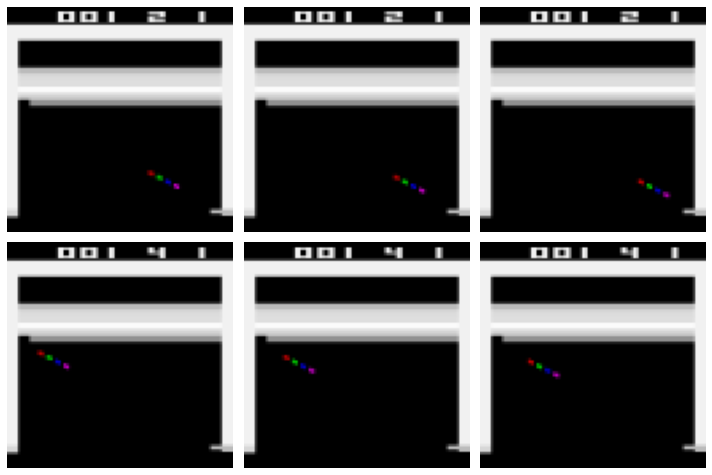

In [19]:
plt.figure(figsize=(10, 6.8))
for row in range(2):
    for col in range(3):
        plt.subplot(2, 3, row * 3 + col + 1)
        plot_observation(trajectories.observation[row, col].numpy())
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0.02)
save_fig("sub_episodes_plot")
plt.show()

For our main training loop, instead of calling the `get_next()` method, we will use a `tf.data.Dataset`. This way, we can benefit from the power of the Data API (e.g., parallelism and prefetching). For this, we call the replay buffer’s `as_dataset()` method: 

Now let's create the dataset:

In [20]:
dataset = replay_buffer.as_dataset(
    sample_batch_size=64,
    num_steps=2,
    num_parallel_calls=3).prefetch(3)

We will sample batches of 64 trajectories at each training step (as in the 2015 DQN paper), each with 2 steps (i.e., 2 steps = 1 full transition, including the next step’s observation). This dataset will process three elements in parallel, and prefetch three batches.

### Creating the Training Loop  

To speed up training, we will convert the main functions to TensorFlow Functions. For this we will use the `tf_agents.utils.common.function()` function, which wraps `tf.function()`, with some extra experimental options:  

And now we are ready to run the main loop!

Convert the main functions to TF Functions for better performance:

In [21]:
from tf_agents.utils.common import function

collect_driver.run = function(collect_driver.run)
agent.train = function(agent.train)

And now we are ready to run the main loop!

Let’s create a small function that will run the main training loop for `n_iterations`:

In [22]:
def train_agent(n_iterations):
    time_step = None
    policy_state = agent.collect_policy.get_initial_state(tf_env.batch_size)
    iterator = iter(dataset)
    for iteration in range(n_iterations):
        time_step, policy_state = collect_driver.run(time_step, policy_state)
        trajectories, buffer_info = next(iterator)
        train_loss = agent.train(trajectories)
        print("\r{} loss:{:.5f}".format(
            iteration, train_loss.loss.numpy()), end="")
        if iteration % 1000 == 0:
            log_metrics(train_metrics)

Run the next cell to train the agent for 50,000 steps. Then look at its behavior by running the following cell. You can run these two cells as many times as you wish. The agent will keep improving! It will likely take over 200,000 iterations for the agent to become reasonably good.

The function first asks the collect policy for its initial state (given the environment batch size, which is 1 in this case). Since the policy is stateless, this returns an empty tuple (so we could have written `policy_state = ()`). Next, we create an iterator over the dataset, and we run the training loop. At each iteration, we call the driver’s `run()` method, passing it the current time step (initially None) and the current policy state. It will run the collect policy and collect experience for four steps (as we configured earlier), broadcasting the collected trajectories to the replay buffer and the metrics. Next, we sample one batch of trajectories from the dataset, and we pass it to the agent’s `train()` method. It returns a `train_loss` object which may vary depending on the type of agent. Next, we display the iteration number and the training loss, and every 1,000 iterations we log all the metrics. Now you can just call `train_agent()` for some number of iterations, and see the agent gradually learn to play Breakout!

In [23]:
train_agent(n_iterations=50000)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 4
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


999 loss:0.00023

INFO:absl: 
		 NumberOfEpisodes = 27
		 EnvironmentSteps = 4004
		 AverageReturn = 0.8999999761581421
		 AverageEpisodeLength = 151.8000030517578


1998 loss:0.00003

INFO:absl: 
		 NumberOfEpisodes = 51
		 EnvironmentSteps = 8004
		 AverageReturn = 1.0
		 AverageEpisodeLength = 176.0


2995 loss:0.00008

INFO:absl: 
		 NumberOfEpisodes = 71
		 EnvironmentSteps = 12004
		 AverageReturn = 1.2000000476837158
		 AverageEpisodeLength = 193.6999969482422


3996 loss:0.00028

INFO:absl: 
		 NumberOfEpisodes = 97
		 EnvironmentSteps = 16004
		 AverageReturn = 0.800000011920929
		 AverageEpisodeLength = 147.1999969482422


4996 loss:0.00004

INFO:absl: 
		 NumberOfEpisodes = 123
		 EnvironmentSteps = 20004
		 AverageReturn = 0.699999988079071
		 AverageEpisodeLength = 150.1999969482422


5998 loss:0.00003

INFO:absl: 
		 NumberOfEpisodes = 146
		 EnvironmentSteps = 24004
		 AverageReturn = 0.699999988079071
		 AverageEpisodeLength = 179.6999969482422


6999 loss:0.00003

INFO:absl: 
		 NumberOfEpisodes = 170
		 EnvironmentSteps = 28004
		 AverageReturn = 1.100000023841858
		 AverageEpisodeLength = 162.5


7997 loss:0.00005

INFO:absl: 
		 NumberOfEpisodes = 190
		 EnvironmentSteps = 32004
		 AverageReturn = 2.0
		 AverageEpisodeLength = 221.60000610351562


8998 loss:0.00005

INFO:absl: 
		 NumberOfEpisodes = 210
		 EnvironmentSteps = 36004
		 AverageReturn = 1.2000000476837158
		 AverageEpisodeLength = 204.60000610351562


9996 loss:0.00051

INFO:absl: 
		 NumberOfEpisodes = 232
		 EnvironmentSteps = 40004
		 AverageReturn = 1.399999976158142
		 AverageEpisodeLength = 185.89999389648438


10999 loss:0.00004

INFO:absl: 
		 NumberOfEpisodes = 254
		 EnvironmentSteps = 44004
		 AverageReturn = 2.0
		 AverageEpisodeLength = 195.0


11999 loss:0.00005

INFO:absl: 
		 NumberOfEpisodes = 276
		 EnvironmentSteps = 48004
		 AverageReturn = 1.0
		 AverageEpisodeLength = 173.8000030517578


12995 loss:0.00068

INFO:absl: 
		 NumberOfEpisodes = 300
		 EnvironmentSteps = 52004
		 AverageReturn = 1.399999976158142
		 AverageEpisodeLength = 172.6999969482422


13997 loss:0.00007

INFO:absl: 
		 NumberOfEpisodes = 325
		 EnvironmentSteps = 56004
		 AverageReturn = 0.8999999761581421
		 AverageEpisodeLength = 150.60000610351562


14996 loss:0.00006

INFO:absl: 
		 NumberOfEpisodes = 350
		 EnvironmentSteps = 60004
		 AverageReturn = 1.2999999523162842
		 AverageEpisodeLength = 166.89999389648438


15995 loss:0.00026

INFO:absl: 
		 NumberOfEpisodes = 369
		 EnvironmentSteps = 64004
		 AverageReturn = 2.0
		 AverageEpisodeLength = 226.10000610351562


16997 loss:0.00039

INFO:absl: 
		 NumberOfEpisodes = 387
		 EnvironmentSteps = 68004
		 AverageReturn = 1.100000023841858
		 AverageEpisodeLength = 201.89999389648438


17995 loss:0.00025

INFO:absl: 
		 NumberOfEpisodes = 410
		 EnvironmentSteps = 72004
		 AverageReturn = 1.399999976158142
		 AverageEpisodeLength = 171.8000030517578


18996 loss:0.00026

INFO:absl: 
		 NumberOfEpisodes = 429
		 EnvironmentSteps = 76004
		 AverageReturn = 1.5
		 AverageEpisodeLength = 209.39999389648438


19996 loss:0.00007

INFO:absl: 
		 NumberOfEpisodes = 454
		 EnvironmentSteps = 80004
		 AverageReturn = 1.399999976158142
		 AverageEpisodeLength = 167.0


20998 loss:0.00054

INFO:absl: 
		 NumberOfEpisodes = 477
		 EnvironmentSteps = 84004
		 AverageReturn = 1.7999999523162842
		 AverageEpisodeLength = 186.8000030517578


21999 loss:0.00004

INFO:absl: 
		 NumberOfEpisodes = 498
		 EnvironmentSteps = 88004
		 AverageReturn = 1.399999976158142
		 AverageEpisodeLength = 231.60000610351562


22999 loss:0.00010

INFO:absl: 
		 NumberOfEpisodes = 518
		 EnvironmentSteps = 92004
		 AverageReturn = 0.8999999761581421
		 AverageEpisodeLength = 180.0


23996 loss:0.00035

INFO:absl: 
		 NumberOfEpisodes = 541
		 EnvironmentSteps = 96004
		 AverageReturn = 1.2000000476837158
		 AverageEpisodeLength = 159.0


24998 loss:0.00055

INFO:absl: 
		 NumberOfEpisodes = 563
		 EnvironmentSteps = 100004
		 AverageReturn = 1.100000023841858
		 AverageEpisodeLength = 178.6999969482422


25997 loss:0.00054

INFO:absl: 
		 NumberOfEpisodes = 591
		 EnvironmentSteps = 104004
		 AverageReturn = 0.8999999761581421
		 AverageEpisodeLength = 150.8000030517578


26996 loss:0.00018

INFO:absl: 
		 NumberOfEpisodes = 612
		 EnvironmentSteps = 108004
		 AverageReturn = 1.7000000476837158
		 AverageEpisodeLength = 204.5


27998 loss:0.00005

INFO:absl: 
		 NumberOfEpisodes = 634
		 EnvironmentSteps = 112004
		 AverageReturn = 0.8999999761581421
		 AverageEpisodeLength = 171.39999389648438


28997 loss:0.00015

INFO:absl: 
		 NumberOfEpisodes = 659
		 EnvironmentSteps = 116004
		 AverageReturn = 1.2000000476837158
		 AverageEpisodeLength = 160.6999969482422


29997 loss:0.00049

INFO:absl: 
		 NumberOfEpisodes = 678
		 EnvironmentSteps = 120004
		 AverageReturn = 0.8999999761581421
		 AverageEpisodeLength = 191.60000610351562


30999 loss:0.00088

INFO:absl: 
		 NumberOfEpisodes = 700
		 EnvironmentSteps = 124004
		 AverageReturn = 1.7999999523162842
		 AverageEpisodeLength = 185.89999389648438


31999 loss:0.00009

INFO:absl: 
		 NumberOfEpisodes = 724
		 EnvironmentSteps = 128004
		 AverageReturn = 1.0
		 AverageEpisodeLength = 155.8000030517578


32998 loss:0.00013

INFO:absl: 
		 NumberOfEpisodes = 747
		 EnvironmentSteps = 132004
		 AverageReturn = 1.7999999523162842
		 AverageEpisodeLength = 187.39999389648438


33997 loss:0.00027

INFO:absl: 
		 NumberOfEpisodes = 767
		 EnvironmentSteps = 136004
		 AverageReturn = 1.600000023841858
		 AverageEpisodeLength = 221.10000610351562


34996 loss:0.00055

INFO:absl: 
		 NumberOfEpisodes = 781
		 EnvironmentSteps = 140004
		 AverageReturn = 2.9000000953674316
		 AverageEpisodeLength = 218.1999969482422


35998 loss:0.00041

INFO:absl: 
		 NumberOfEpisodes = 797
		 EnvironmentSteps = 144004
		 AverageReturn = 2.0999999046325684
		 AverageEpisodeLength = 228.5


36999 loss:0.00091

INFO:absl: 
		 NumberOfEpisodes = 818
		 EnvironmentSteps = 148004
		 AverageReturn = 1.899999976158142
		 AverageEpisodeLength = 187.60000610351562


37999 loss:0.00038

INFO:absl: 
		 NumberOfEpisodes = 836
		 EnvironmentSteps = 152004
		 AverageReturn = 2.4000000953674316
		 AverageEpisodeLength = 213.1999969482422


38998 loss:0.00062

INFO:absl: 
		 NumberOfEpisodes = 854
		 EnvironmentSteps = 156004
		 AverageReturn = 2.4000000953674316
		 AverageEpisodeLength = 224.10000610351562


39996 loss:0.00062

INFO:absl: 
		 NumberOfEpisodes = 868
		 EnvironmentSteps = 160004
		 AverageReturn = 3.799999952316284
		 AverageEpisodeLength = 288.20001220703125


40996 loss:0.00060

INFO:absl: 
		 NumberOfEpisodes = 883
		 EnvironmentSteps = 164004
		 AverageReturn = 2.799999952316284
		 AverageEpisodeLength = 235.39999389648438


41995 loss:0.00050

INFO:absl: 
		 NumberOfEpisodes = 899
		 EnvironmentSteps = 168004
		 AverageReturn = 3.4000000953674316
		 AverageEpisodeLength = 244.10000610351562


42996 loss:0.00065

INFO:absl: 
		 NumberOfEpisodes = 914
		 EnvironmentSteps = 172004
		 AverageReturn = 5.400000095367432
		 AverageEpisodeLength = 292.0


43997 loss:0.00058

INFO:absl: 
		 NumberOfEpisodes = 929
		 EnvironmentSteps = 176004
		 AverageReturn = 4.400000095367432
		 AverageEpisodeLength = 280.79998779296875


44996 loss:0.00339

INFO:absl: 
		 NumberOfEpisodes = 943
		 EnvironmentSteps = 180004
		 AverageReturn = 4.400000095367432
		 AverageEpisodeLength = 298.6000061035156


45998 loss:0.00270

INFO:absl: 
		 NumberOfEpisodes = 957
		 EnvironmentSteps = 184004
		 AverageReturn = 5.800000190734863
		 AverageEpisodeLength = 323.3999938964844


46998 loss:0.00119

INFO:absl: 
		 NumberOfEpisodes = 969
		 EnvironmentSteps = 188004
		 AverageReturn = 5.599999904632568
		 AverageEpisodeLength = 289.1000061035156


47997 loss:0.00130

INFO:absl: 
		 NumberOfEpisodes = 986
		 EnvironmentSteps = 192004
		 AverageReturn = 4.599999904632568
		 AverageEpisodeLength = 233.60000610351562


48999 loss:0.00115

INFO:absl: 
		 NumberOfEpisodes = 995
		 EnvironmentSteps = 196004
		 AverageReturn = 6.699999809265137
		 AverageEpisodeLength = 383.5


49999 loss:0.00137

Run the next cell to train the agent for 50,000 steps. Then look at its behavior by running the following cell. You can run these two cells as many times as you wish. The agent will keep improving! It will likely take over 200,000 iterations for the agent to become reasonably good.

In [24]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [25]:
frames = []
def save_frames(trajectory):
    global frames
    frames.append(tf_env.pyenv.envs[0].render(mode="rgb_array"))

watch_driver = DynamicStepDriver(
    tf_env,
    agent.policy,
    observers=[save_frames, ShowProgress(1000)],
    num_steps=1000)
final_time_step, final_policy_state = watch_driver.run()

plot_animation(frames)

900/1000

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


1000/1000

If you want to save an animated GIF to show off your agent to your friends, here's one way to do it:

In [26]:
import PIL

image_path = os.path.join("images", "rl", "breakout.gif")
frame_images = [PIL.Image.fromarray(frame) for frame in frames[:150]]
frame_images[0].save(image_path, format='GIF',
                     append_images=frame_images[1:],
                     save_all=True,
                     duration=30,
                     loop=0)

In [1]:
%%html
<img src="images/rl/breakout.gif" />

##  Overview of Some Popular RL Algorithms  


Before we finish this chapter, let’s take a quick look at a few popular RL algorithms:

*Actor-Critic algorithms* 


  - A family of RL algorithms that combine Policy Gradients with Deep Q-Networks. An Actor-Critic agent contains two neural networks: a policy net and a DQN. The DQN is trained normally, by learning from the agent’s experiences. The policy net learns differently (and much faster) than in regular PG: instead of estimating the value of each action by going through multiple episodes, then summing the future discounted rewards for each action, and finally normalizing them, the agent (actor) relies on the action values estimated by the DQN (critic). It’s a bit like an athlete (the agent) learning with the help of a coach (the DQN).

*Asynchronous Advantage Actor-Critic (A3C)* 


  - An important Actor-Critic variant introduced by DeepMind researchers in 2016, where multiple agents learn in parallel, exploring different copies of the environment. At regular intervals, but asynchronously (hence the name), each agent pushes some weight updates to a master network, then it pulls the latest weights from that network. Each agent thus contributes to improving the master network and benefits from what the other agents have learned. Moreover, instead of estimating the Q-Values, the DQN estimates the advantage of each action (hence the second A in the name), which stabilizes training.

*Advantage Actor-Critic (A2C)* 


  - A variant of the A3C algorithm that removes the asynchronicity. All model updates are synchronous, so gradient updates are performed over larger batches, which allows the model to better utilize the power of the GPU.

*Soft Actor-Critic (SAC)* 

  - An Actor-Critic variant proposed in 2018 by Tuomas Haarnoja and other UC Berkeley researchers. It learns not only rewards, but also to maximize the entropy of its actions. In other words, it tries to be as unpredictable as possible while still getting as many rewards as possible. This encourages the agent to explore the environment, which speeds up training, and makes it less likely to repeatedly execute the same action when the DQN produces imperfect estimates. This algorithm has demonstrated an amazing sample efficiency (contrary to all the previous algorithms, which learn very slowly). SAC is available in TF-Agents.

*Proximal Policy Optimization (PPO)* 

  - An algorithm based on A2C that clips the loss function to avoid excessively large weight updates (which often lead to training instabilities). PPO is a simplification of the previous Trust Region Policy Optimization (TRPO) algorithm, also by John Schulman and other OpenAI researchers. OpenAI made the news in April 2019 with their AI called OpenAI Five, based on the PPO algorithm, which defeated the world champions at the multiplayer game Dota 2. PPO is also available in TF-Agents.

*Curiosity-based exploration*  

  - A recurring problem in RL is the sparsity of the rewards, which makes learning very slow and inefficient. Deepak Pathak and other UC Berkeley researchers have proposed an exciting way to tackle this issue: why not ignore the rewards, and just make the agent extremely curious to explore the environment? The rewards thus become intrinsic to the agent, rather than coming from the environment. Similarly, stimulating curiosity in a child is more likely to give good results than purely rewarding the child for getting good grades. How does this work? The agent continuously tries to predict the outcome of its actions, and it seeks situations where the outcome does not match its predictions. In other words, it wants to be surprised. If the outcome is predictable (boring), it goes elsewhere. However, if the outcome is unpredictable but the agent notices that it has no control over it, it also gets bored after a while. With only curiosity, the authors succeeded in training an agent at many video games: even though the agent gets no penalty for losing, the game starts over, which is boring so it learns to avoid it.

We covered many topics in this chapter: Policy Gradients, Markov chains, Markov decision processes, Q-Learning, Approximate Q-Learning, and Deep Q-Learning and its main variants (fixed Q-Value targets, Double DQN, Dueling DQN, and prioritized experience replay). We discussed how to use TF-Agents to train agents at scale, and finally we took a quick look at a few other popular algorithms. Reinforcement Learning is a huge and exciting field, with new ideas and algorithms popping out every day, so I hope this chapter sparked your curiosity: there is a whole world to explore!

## Extra material

### Deque vs Rotating List

The `deque` class offers fast append, but fairly slow random access (for large replay memories):

In [5]:
import numpy as np
from collections import deque
np.random.seed(42)

mem = deque(maxlen=1000000)
for i in range(1000000):
    mem.append(i)
[mem[i] for i in np.random.randint(1000000, size=5)]

[121958, 671155, 131932, 365838, 259178]

In [6]:
%timeit mem.append(1)

66.4 ns ± 1.29 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [7]:
%timeit [mem[i] for i in np.random.randint(1000000, size=5)]

251 µs ± 8.95 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Alternatively, you could use a rotating list like this `ReplayMemory` class. This would make random access faster for large replay memories:

In [8]:
class ReplayMemory:
    def __init__(self, max_size):
        self.buffer = np.empty(max_size, dtype=np.object)
        self.max_size = max_size
        self.index = 0
        self.size = 0

    def append(self, obj):
        self.buffer[self.index] = obj
        self.size = min(self.size + 1, self.max_size)
        self.index = (self.index + 1) % self.max_size

    def sample(self, batch_size):
        indices = np.random.randint(self.size, size=batch_size)
        return self.buffer[indices]

In [9]:
mem = ReplayMemory(max_size=1000000)
for i in range(1000000):
    mem.append(i)
mem.sample(5)

C:\Users\lidan\AppData\Local\Temp/ipykernel_13808/2638402778.py:3: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.buffer = np.empty(max_size, dtype=np.object)


array([757386, 904203, 190588, 595754, 865356], dtype=object)

In [10]:
%timeit mem.append(1)

595 ns ± 19.6 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [11]:
%timeit mem.sample(5)

10.9 µs ± 218 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


### Creating a Custom TF-Agents Environment

To create a custom TF-Agent environment, you just need to write a class that inherits from the `PyEnvironment` class and implements a few methods. For example, the following minimal environment represents a simple 4x4 grid. The agent starts in one corner (0,0) and must move to the opposite corner (3,3). The episode is done if the agent reaches the goal (it gets a +10 reward) or if the agent goes out of bounds (-1 reward). The actions are up (0), down (1), left (2) and right (3).

In [ ]:
class MyEnvironment(tf_agents.environments.py_environment.PyEnvironment):
    def __init__(self, discount=1.0):
        super().__init__()
        self._action_spec = tf_agents.specs.BoundedArraySpec(
            shape=(), dtype=np.int32, name="action", minimum=0, maximum=3)
        self._observation_spec = tf_agents.specs.BoundedArraySpec(
            shape=(4, 4), dtype=np.int32, name="observation", minimum=0, maximum=1)
        self.discount = discount

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        self._state = np.zeros(2, dtype=np.int32)
        obs = np.zeros((4, 4), dtype=np.int32)
        obs[self._state[0], self._state[1]] = 1
        return tf_agents.trajectories.time_step.restart(obs)

    def _step(self, action):
        self._state += [(-1, 0), (+1, 0), (0, -1), (0, +1)][action]
        reward = 0
        obs = np.zeros((4, 4), dtype=np.int32)
        done = (self._state.min() < 0 or self._state.max() > 3)
        if not done:
            obs[self._state[0], self._state[1]] = 1
        if done or np.all(self._state == np.array([3, 3])):
            reward = -1 if done else +10
            return tf_agents.trajectories.time_step.termination(obs, reward)
        else:
            return tf_agents.trajectories.time_step.transition(obs, reward,
                                                               self.discount)

The action and observation specs will generally be instances of the `ArraySpec` or `BoundedArraySpec` classes from the `tf_agents.specs` package (check out the other specs in this package as well). Optionally, you can also define a `render()` method, a `close()` method to free resources, as well as a `time_step_spec()` method if you don't want the `reward` and `discount` to be 32-bit float scalars. Note that the base class takes care of keeping track of the current time step, which is why we must implement `_reset()` and `_step()` rather than `reset()` and `step()`.


In [ ]:
my_env = MyEnvironment()
time_step = my_env.reset()
time_step

In [ ]:
time_step = my_env.step(1)
time_step

## Exercise

1.  How would you define Reinforcement Learning? How is it different from regular supervised or unsupervised learning? 

Reinforcement Learning is an area of Machine Learning aimed at creating agents capable of taking actions in an environment in a way that maximizes rewards over time. There are many differences between RL and regular supervised and unsupervised learning. Here are a few:

  - In supervised and unsupervised learning, the goal is generally to find patterns in the data and use them to make predictions. In Reinforcement Learning, the goal is to find a good policy.

  - Unlike in supervised learning, the agent is not explicitly given the “right” answer. It must learn by trial and error.

  - Unlike in unsupervised learning, there is a form of supervision, through rewards. We do not tell the agent how to perform the task, but we do tell it when it is making progress or when it is failing.

  - A Reinforcement Learning agent needs to find the right balance between exploring the environment, looking for new ways of getting rewards, and exploiting sources of rewards that it already knows. In contrast, supervised and unsupervised learning systems generally don’t need to worry about exploration; they just feed on the training data they are given.

  - In supervised and unsupervised learning, training instances are typically independent (in fact, they are generally shuffled). In Reinforcement Learning, consecutive observations are generally not independent. An agent may remain in the same region of the environment for a while before it moves on, so consecutive observations will be very correlated. In some cases a replay memory (buffer) is used to ensure that the training algorithm gets fairly independent observations.



2. Can you think of three possible applications of RL that were not mentioned in this chapter? For each of them, what is the environment? What is the agent? What are some possible actions? What are the rewards?  


Here are a few possible applications of Reinforcement Learning, other than those mentioned in Chapter 18:

*Music personalization* 


  > The environment is a user’s personalized web radio. The agent is the software deciding what song to play next for that user. Its possible actions are to play any song in the catalog (it must try to choose a song the user will enjoy) or to play an advertisement (it must try to choose an ad that the user will be interested in). It gets a small reward every time the user listens to a song, a larger reward every time the user listens to an ad, a negative reward when the user skips a song or an ad, and a very negative reward if the user leaves.

*Marketing*  


  > The environment is your company’s marketing department. The agent is the software that defines which customers a mailing campaign should be sent to, given their profile and purchase history (for each customer it has two possible actions: send or don’t send). It gets a negative reward for the cost of the mailing campaign, and a positive reward for estimated revenue generated from this campaign.

*Product delivery* 

  > Let the agent control a fleet of delivery trucks, deciding what they should pick up at the depots, where they should go, what they should drop off, and so on. It will get positive rewards for each product delivered on time, and negative rewards for late deliveries.



3. What is the discount factor? Can the optimal policy change if you modify the discount factor?  

When estimating the value of an action, Reinforcement Learning algorithms typically sum all the rewards that this action led to, giving more weight to immediate rewards and less weight to later rewards (considering that an action has more influence on the near future than on the distant future). To model this, a discount factor is typically applied at each time step. For example, with a discount factor of 0.9, a reward of 100 that is received two time steps later is counted as only $0.9^2 \times 100 = 81$ when you are estimating the value of the action. You can think of the discount factor as a measure of how much the future is valued relative to the present: if it is very close to 1, then the future is valued almost as much as the present; if it is close to 0, then only immediate rewards matter. Of course, this impacts the optimal policy tremendously: if you value the future, you may be willing to put up with a lot of immediate pain for the prospect of eventual rewards, while if you don’t value the future, you will just grab any immediate reward you can find, never investing in the future.

4. How do you measure the performance of a Reinforcement Learning agent?  

To measure the performance of a Reinforcement Learning agent, you can simply sum up the rewards it gets. In a simulated environment, you can run many episodes and look at the total rewards it gets on average (and possibly look at the min, max, standard deviation, and so on).


5. What is the credit assignment problem? When does it occur? How can you alleviate it?


The credit assignment problem is the fact that when a Reinforcement Learning agent receives a reward, it has no direct way of knowing which of its previous actions contributed to this reward. It typically occurs when there is a large delay between an action and the resulting reward (e.g., during a game of Atari’s Pong, there may be a few dozen time steps between the moment the agent hits the ball and the moment it wins the point). One way to alleviate it is to provide the agent with shorter-term rewards, when possible. This usually requires prior knowledge about the task. For example, if we want to build an agent that will learn to play chess, instead of giving it a reward only when it wins the game, we could give it a reward every time it captures one of the opponent’s pieces.


6. What is the point of using a replay buffer?  

An agent can often remain in the same region of its environment for a while, so all of its experiences will be very similar for that period of time. This can introduce some bias in the learning algorithm. It may tune its policy for this region of the environment, but it will not perform well as soon as it moves out of this region. To solve this problem, you can use a replay memory; instead of using only the most immediate experiences for learning, the agent will learn based on a buffer of its past experiences, recent and not so recent (perhaps this is why we dream at night: to replay our experiences of the day and better learn from them?).



7. What is an off-policy RL algorithm?  

An off-policy RL algorithm learns the value of the optimal policy (i.e., the sum of discounted rewards that can be expected for each state if the agent acts optimally) while the agent follows a different policy. Q-Learning is a good example of such an algorithm. In contrast, an on-policy algorithm learns the value of the policy that the agent actually executes, including both exploration and exploitation.

8. Use policy gradients to solve OpenAI Gym’s LunarLander-v2 environment. You will need to install the Box2D dependencies (python3 -m pip install -U gym[box2d]).



_Exercise: Use policy gradients to solve OpenAI Gym's LunarLander-v2 environment. You will need to install the Box2D dependencies (`%pip install -U gym[box2d]`)._

Let's start by creating a LunarLander-v2 environment:

In [1]:
import gym
env = gym.make("LunarLander-v2")

The inputs are 8-dimensional:

In [2]:
env.observation_space

Box(-inf, inf, (8,), float32)

In [3]:
#env.seed(42)
obs = env.reset()
obs

array([ 9.8838808e-04,  1.4097369e+00,  1.0009289e-01, -5.2591033e-02,
       -1.1384598e-03, -2.2672532e-02,  0.0000000e+00,  0.0000000e+00],
      dtype=float32)

From the [source code](https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py), we can see that these each 8D observation (x, y, h, v, a, w, l, r) correspond to:
* x,y: the coordinates of the spaceship. It starts at a random location near (0, 1.4) and must land near the target at (0, 0).
* h,v: the horizontal and vertical speed of the spaceship. It starts with a small random speed.
* a,w: the spaceship's angle and angular velocity.
* l,r: whether the left or right leg touches the ground (1.0) or not (0.0).

The action space is discrete, with 4 possible actions:

In [4]:
env.action_space

Discrete(4)

Looking at the [LunarLander-v2's description](https://gym.openai.com/envs/LunarLander-v2/), these actions are:
* do nothing
* fire left orientation engine
* fire main engine
* fire right orientation engine

Let's create a simple policy network with 4 output neurons (one per possible action):

In [5]:
from tensorflow import keras
import numpy as np
import tensorflow as tf

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_inputs = env.observation_space.shape[0]
n_outputs = env.action_space.n

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="relu", input_shape=[n_inputs]),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(n_outputs, activation="softmax"),
])

Note that we're using the softmax activation function in the output layer, instead of the sigmoid activation function 
like we did for the CartPole-v1 environment. This is because we only had two possible actions for the CartPole-v1 environment, so a binary classification model worked fine. However, since we now how more than two possible actions, we need a multiclass classification model.

Next, let's reuse the `play_one_step()` and `play_multiple_episodes()` functions we defined for the CartPole-v1 Policy Gradient code above, but we'll just tweak the `play_one_step()` function to account for the fact that the model is now a multiclass classification model rather than a binary classification model. We'll also tweak the `play_multiple_episodes()` function to call our tweaked `play_one_step()` function rather than the original one, and we add a big penalty if the spaceship does not land (or crash) before a maximum number of steps.

In [6]:
def lander_play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        probas = model(obs[np.newaxis])
        logits = tf.math.log(probas + keras.backend.epsilon())
        action = tf.random.categorical(logits, num_samples=1)
        loss = tf.reduce_mean(loss_fn(action, probas))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(action[0, 0].numpy())
    return obs, reward, done, grads

def lander_play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = lander_play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

We'll keep exactly the same `discount_rewards()` and `discount_and_normalize_rewards()` functions as earlier:

In [7]:
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

Now let's define some hyperparameters:

In [8]:
n_iterations = 200
n_episodes_per_update = 16
n_max_steps = 1000
discount_rate = 0.99

Again, since the model is a multiclass classification model, we must use the categorical cross-entropy rather than the binary cross-entropy. Moreover, since the `lander_play_one_step()` function sets the targets as class indices rather than class probabilities, we must use the `sparse_categorical_crossentropy()` loss function:

In [9]:
optimizer = keras.optimizers.Nadam(learning_rate=0.005)
loss_fn = keras.losses.sparse_categorical_crossentropy

We're ready to train the model. Let's go!

In [10]:
#env.seed(42)

mean_rewards = []

for iteration in range(n_iterations):
    all_rewards, all_grads = lander_play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
    mean_reward = sum(map(sum, all_rewards)) / n_episodes_per_update
    print("\rIteration: {}/{}, mean reward: {:.1f}  ".format(
        iteration + 1, n_iterations, mean_reward), end="")
    mean_rewards.append(mean_reward)
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_rate)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

Iteration: 200/200, mean reward: 114.4  

Let's look at the learning curve:

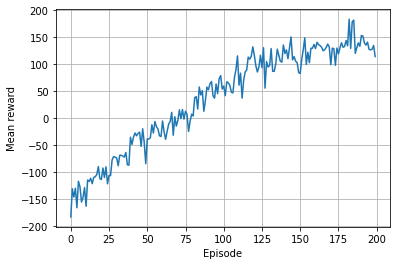

In [11]:
import matplotlib.pyplot as plt

plt.plot(mean_rewards)
plt.xlabel("Episode")
plt.ylabel("Mean reward")
plt.grid()
plt.show()

Now let's look at the result!

In [12]:
def lander_render_policy_net(model, n_max_steps=500, seed=42):
    frames = []
    env = gym.make("LunarLander-v2")
    env.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        probas = model(obs[np.newaxis])
        logits = tf.math.log(probas + keras.backend.epsilon())
        action = tf.random.categorical(logits, num_samples=1)
        obs, reward, done, info = env.step(action[0, 0].numpy())
        if done:
            break
    env.close()
    return frames

In [19]:
import matplotlib.animation as animation

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

frames = lander_render_policy_net(model, seed=42)
plot_animation(frames)

That's pretty good. You can try training it for longer and/or tweaking the hyperparameters to see if you can get it to go over 200.

9. Use TF-Agents to train an agent that can achieve a superhuman level at SpaceInvaders-v4 using any of the available algorithms.


_Exercise: Use TF-Agents to train an agent that can achieve a superhuman level at SpaceInvaders-v4 using any of the available algorithms._

Please follow the steps in the [Using TF-Agents to Beat Breakout](http://localhost:8888/notebooks/18_reinforcement_learning.ipynb#Using-TF-Agents-to-Beat-Breakout) section above, replacing `"Breakout-v4"` with `"SpaceInvaders-v4"`. There will be a few things to tweak, however. For example, the Space Invaders game does not require the user to press FIRE to begin the game. Instead, the player's laser cannon blinks for a few seconds then the game starts automatically. For better performance, you may want to skip this blinking phase (which lasts about 40 steps) at the beginning of each episode and after each life lost. Indeed, it's impossible to do anything at all during this phase, and nothing moves. One way to do this is to use the following custom environment wrapper, instead of the `AtariPreprocessingWithAutoFire` wrapper:

In [ ]:
class AtariPreprocessingWithSkipStart(AtariPreprocessing):
    def skip_frames(self, num_skip):
        for _ in range(num_skip):
          super().step(0) # NOOP for num_skip steps
    def reset(self, **kwargs):
        obs = super().reset(**kwargs)
        self.skip_frames(40)
        return obs
    def step(self, action):
        lives_before_action = self.ale.lives()
        obs, rewards, done, info = super().step(action)
        if self.ale.lives() < lives_before_action and not done:
            self.skip_frames(40)
        return obs, rewards, done, info

Moreover, you should always ensure that the preprocessed images contain enough information to play the game. For example, the blasts from the laser cannon and from the aliens should still be visible despite the limited resolution. In this particular case, the preprocessing we did for Breakout still works fine for Space Invaders, but that's something you should always check if you want try other games. To do this, you can let the agent play randomly for a while, and record the preprocessed frames, then play the animation and ensure the game still looks playable.

You will also need to let the agent train for quite a long time to get good performance. Sadly, the DQN algorithm is not able to reach superhuman level on Space Invaders, likely because humans are able to learn efficient long term strategies in this game, whereas DQN can only master fairly short strategies. But there has been a lot of progress over the past few years, and now many other RL algorithms are able to surpass human experts at this game. Check out the [State-of-the-Art for Space Invaders on paperswithcode.com](https://paperswithcode.com/sota/atari-games-on-atari-2600-space-invaders).


10. _Exercise: If you have about $100 to spare, you can purchase a Raspberry Pi 3 plus some cheap robotics components, install TensorFlow on the Pi, and go wild! For an example, check out this [fun post](https://homl.info/2) by Lukas Biewald, or take a look at GoPiGo or BrickPi. Start with simple goals, like making the robot turn around to find the brightest angle (if it has a light sensor) or the closest object (if it has a sonar sensor), and move in that direction. Then you can start using Deep Learning: for example, if the robot has a camera, you can try to implement an object detection algorithm so it detects people and moves toward them. You can also try to use RL to make the agent learn on its own how to use the motors to achieve that goal. Have fun!_